
## Deep Hybrid Swarm Intelligence IDS

This notebook implements an advanced hybrid swarm intelligence feature selection algorithm
that integrates Ant Colony Optimization (ACO), Particle Swarm Optimization (PSO), Artificial
Bee Colony (ABC), and Modified Wolf Predation Algorithm (MWPA) within a single unified
loop.

Based on the provided abstract and code snippets, this notebook follows a conventional
data science process to demonstrate the framework.

Plan:
1. Setup & Data Acquisition
2. Data Preprocessing (Fixed: OneHotEncoder, Scaling, Train/Val Split)
3. Define Fitness Function (Fixed: Maximizing, Validation Set, Fast Classifier, Robust)
4. Implement Individual Swarm Algorithms for Feature Selection (Adapted to new fitness)
5. Implement Plausible Hybrid Swarm Intelligence for Feature Selection (Implementation Provided)
6. Run Feature Selection Experiments (Individual vs. Hybrid)
7. Model Training (Random Forest, SVM, Neural Networks on selected features)
8. Model Evaluation (Accuracy, FPR, Precision, Recall, F1, ROC AUC, Confusion Matrix) - Full Metrics
9. Implement Plausible Hybrid Swarm Optimizer for Benchmarks (Implementation Provided)
10. Benchmark Function Analysis (Sphere, Rastrigin, Rosenbrock) - Hybrid Run
11. Tools and Libraries


### 0. Setup & Imports
#### Install dependencies and import necessary libraries.

In [1]:
# Install necessary libraries if not already installed
# !pip install pyswarms scikit-learn pandas numpy matplotlib seaborn scipy tqdm requests -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
import time
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report, f1_score, precision_score, recall_score
from tqdm.notebook import tqdm # Use tqdm for progress bars
import sys # Import sys to check Python version for get_feature_names_out
import os # Import os to check file existence
warnings.filterwarnings('ignore') # Suppress warnings

### 1. Data Acquisition
#### Load the NSL-KDD dataset from the specified GitHub repository.

In [2]:
import pandas as pd
import requests
from io import StringIO
import numpy as np # Will be needed later, good to import early

# URLs
train_url     = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt"
test_url      = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt"
features_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Field%20Names.csv"

# Define column names based on the Field Names.csv structure
column_names = []
try:
    print("Attempting to fetch feature names...")
    features_response = requests.get(features_url)
    features_response.raise_for_status()  # Check for HTTP errors
    # Read the CSV, it has 'feature_name,type'. We only need the names.
    features_df = pd.read_csv(StringIO(features_response.text), header=None, names=['feature_name', 'type'])
    column_names = features_df['feature_name'].tolist()
    # Add the target and difficulty columns which are not in Field Names.csv
    column_names.extend(['attack_type', 'difficulty_level'])
    print("Feature names fetched successfully.")
except requests.exceptions.RequestException as e:
    print(f"Error fetching feature names: {e}")
    # Fallback list if fetch fails (ensures notebook can run partially)
    column_names = [
        'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
        'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
        'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
        'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
        'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
        'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
        'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
        'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
        'attack_type', 'difficulty_level']
    print("Using fallback feature names.")

# Fetch datasets
df_train = None
df_test = None
data_loaded = False
try:
    print(f"\nFetching training data from {train_url}...")
    train_response = requests.get(train_url)
    train_response.raise_for_status()
    df_train = pd.read_csv(StringIO(train_response.text), header=None, names=column_names)
    print("Training data loaded successfully.")

    print(f"Fetching testing data from {test_url}...")
    test_response = requests.get(test_url)
    test_response.raise_for_status()
    df_test = pd.read_csv(StringIO(test_response.text), header=None, names=column_names)
    print("Testing data loaded successfully.")
    data_loaded = True

    print("\nTraining data shape:", df_train.shape)
    print("Testing data shape:", df_test.shape)

    # Drop the 'difficulty_level' column as it's not typically used as a feature for detection model training
    if 'difficulty_level' in df_train.columns:
        df_train = df_train.drop('difficulty_level', axis=1)
    if 'difficulty_level' in df_test.columns:
        df_test = df_test.drop('difficulty_level', axis=1)
    print("\nDropped 'difficulty_level' column.")

    # Create binary target variable: 1 for attack, 0 for normal
    # This is crucial for binary classification focused on intrusion detection
    df_train['is_attack'] = (df_train['attack_type'] != 'normal').astype(int)
    df_test['is_attack'] = (df_test['attack_type'] != 'normal').astype(int)
    print("Created binary target 'is_attack'.")

    # Drop the original 'attack_type' column as 'is_attack' is now the target
    df_train = df_train.drop('attack_type', axis=1)
    df_test = df_test.drop('attack_type', axis=1)
    print("Dropped original 'attack_type' column.")

    print("\nTraining data shape after transformations:", df_train.shape)
    print("Testing data shape after transformations:", df_test.shape)

    print("\nTraining data head:")
    print(df_train.head())

except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    print("Please ensure you have an internet connection and the URLs are correct.")
    print("Cannot proceed without data files.")
except Exception as e:
    print(f"An unexpected error occurred during data loading or initial processing: {e}")
finally:
    if not data_loaded:
        print("\nData loading failed. Initializing empty data structures for notebook structure demonstration.")
        # Use the column_names defined earlier, excluding the dropped ones and target
        feature_cols = [col for col in column_names if col not in ['attack_type', 'difficulty_level', 'is_attack']]
        df_train = pd.DataFrame(columns=feature_cols + ['is_attack'])
        df_test = pd.DataFrame(columns=feature_cols + ['is_attack'])
        # To allow subsequent cells to run without erroring on .shape or .columns
        X_train_raw, y_train = pd.DataFrame(columns=feature_cols), pd.Series(dtype='int', name='is_attack')
        X_test_raw, y_test = pd.DataFrame(columns=feature_cols), pd.Series(dtype='int', name='is_attack')
        X_train_p, X_test_p = np.array([]).reshape(0, len(feature_cols)), np.array([]).reshape(0, len(feature_cols))
        X_tr, X_val, y_tr, y_val = np.array([]).reshape(0, len(feature_cols)), np.array([]).reshape(0, len(feature_cols)), pd.Series(dtype='int', name='is_attack'), pd.Series(dtype='int', name='is_attack')
        feat_names = feature_cols


Attempting to fetch feature names...
Feature names fetched successfully.

Fetching training data from https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt...
Training data loaded successfully.
Fetching testing data from https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt...
Testing data loaded successfully.

Training data shape: (125973, 43)
Testing data shape: (22544, 43)

Dropped 'difficulty_level' column.
Created binary target 'is_attack'.
Dropped original 'attack_type' column.

Training data shape after transformations: (125973, 42)
Testing data shape after transformations: (22544, 42)

Training data head:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232 

### 2. Data Preprocessing
#### This step involves:
 - Handling missing values (NSL-KDD is relatively clean, but good practice to check).
 - Encoding categorical features (`protocol_type`, `service`, `flag`) using **One-Hot Encoding**.
 - Scaling numerical features using **MinMaxScaler**.
 - Splitting the training data into training (`X_tr`, `y_tr`) and validation (`X_val`, `y_val`) sets for use in the feature selection fitness function. The original test set (`X_test_p`, `y_test`) is kept separate for final evaluation.

In [3]:
# 2. Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

if data_loaded and not df_train.empty:
    # Split features and target variable
    X_train_raw = df_train.drop('is_attack', axis=1)
    y_train = df_train['is_attack']
    X_test_raw = df_test.drop('is_attack', axis=1)
    y_test = df_test['is_attack']

    # Identify categorical vs numerical features
    # Ensure we only select columns that exist in the dataframe
    all_features = X_train_raw.columns.tolist()
    
    # Explicitly define categorical features based on NSL-KDD dataset knowledge
    cat_feats = ['protocol_type', 'service', 'flag']
    # Ensure these are actually present in the columns, in case of fallback names or modifications
    cat_feats = [col for col in cat_feats if col in all_features]
    
    num_feats = [col for col in all_features if col not in cat_feats]

    print(f"\nIdentified {len(cat_feats)} categorical features: {cat_feats}")
    print(f"Identified {len(num_feats)} numerical features: {num_feats}")

    # Define preprocessing pipelines for numerical and categorical features
    # Numerical features: Impute missing values with median, then scale.
    # StandardScaler is often preferred for algorithms sensitive to feature distribution (e.g., SVM, NN).
    # MinMaxScaler is also a valid choice, especially if features have varying scales but no specific distribution is assumed.
    # Let's stick to MinMaxScaler as per original, but StandardScaler is a good alternative to consider.
    num_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', MinMaxScaler()) # Or StandardScaler()
    ])

    # Categorical features: Impute missing values with a constant, then one-hot encode.
    # handle_unknown='ignore' ensures that if new categories appear in test data, they are handled gracefully.
    cat_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False for dense array
    ])

    # Create a ColumnTransformer to apply different transformations to different columns
    # remainder='passthrough' keeps any columns not explicitly transformed (should be none here if lists are correct)
    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_feats),
        ('cat', cat_pipe, cat_feats)
    ], remainder='passthrough') # Changed variable name to 'preprocessor' for clarity

    # Fit the preprocessor on the training data and transform both training and test data
    # Fitting only on training data prevents data leakage from the test set.
    print("\nFitting preprocessor on training data...")
    X_train_p = preprocessor.fit_transform(X_train_raw)
    print("Transforming test data...")
    X_test_p = preprocessor.transform(X_test_raw)

    # Get feature names after preprocessing (important for interpretability)
    try:
        # For scikit-learn >= 1.0
        feat_names = preprocessor.get_feature_names_out()
    except AttributeError:
        # Fallback for older scikit-learn versions
        cat_transformed_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_feats).tolist()
        feat_names = num_feats + cat_transformed_names
        # Handle remainder='passthrough' if used and columns were passed through
        if preprocessor.remainder == 'passthrough' and hasattr(preprocessor, '_columns') and preprocessor._columns:
             # This part is tricky with older sklearn versions and remainder='passthrough'
             # For simplicity, assuming no passthrough columns if get_feature_names_out fails
            pass

    feat_names = list(feat_names) # Ensure it's a list

    print(f"\nProcessed training data shape: {X_train_p.shape}")
    print(f"Processed testing data shape: {X_test_p.shape}")
    print(f"Number of features after preprocessing: {len(feat_names)}")

    # Create an internal train/validation split from the processed training data
    # This validation set (X_val, y_val) is used by the feature selection algorithms
    # Stratify by y_train to maintain class proportions, crucial for imbalanced datasets
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_p, y_train, test_size=0.25, stratify=y_train, random_state=42
    )
    print(f"Internal training set shape for FS: X_tr {X_tr.shape}, y_tr {y_tr.shape}")
    print(f"Internal validation set shape for FS: X_val {X_val.shape}, y_val {y_val.shape}")

else:
    print("\nSkipping preprocessing as data was not loaded or df_train is empty.")
    # Ensure these variables exist as empty structures if data loading failed, to prevent downstream errors
    if 'X_train_raw' not in locals(): X_train_raw = pd.DataFrame()
    if 'y_train' not in locals(): y_train = pd.Series(dtype='int', name='is_attack')
    if 'X_test_raw' not in locals(): X_test_raw = pd.DataFrame()
    if 'y_test' not in locals(): y_test = pd.Series(dtype='int', name='is_attack')
    if 'X_train_p' not in locals(): X_train_p = np.array([]).reshape(0,0)
    if 'X_test_p' not in locals(): X_test_p = np.array([]).reshape(0,0)
    if 'X_tr' not in locals(): X_tr, X_val, y_tr, y_val = np.array([]).reshape(0,0), np.array([]).reshape(0,0), pd.Series(dtype='int', name='is_attack'), pd.Series(dtype='int', name='is_attack')
    if 'feat_names' not in locals(): feat_names = []


Identified 3 categorical features: ['protocol_type', 'service', 'flag']
Identified 38 numerical features: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

Fitting preprocessor on training data...
Transforming test data...

Processed training data shape: (125973, 122)
Processed testing data shape: (22544, 122)
Number of features after preprocessing: 122

In [4]:
# 2.5: Entropy/Variance Prefiltering 
from scipy.stats import entropy
import pandas as pd
import numpy as np

if data_loaded and not df_train.empty:
    print("\n--- Applying Prefiltering (Step 2.5) ---")
    
    # --- Parameters ---
    # For numerical features: Keep features with variance above this percentile
    variance_percentile_threshold = 1 # Keep top 99% variance features (removes very low variance)
    # For categorical features: Keep features with more than this many unique values
    min_unique_categorical_values = 2 # Remove features with only 1 unique value (no information)
    
    X_train_raw_prefilter = df_train.drop('is_attack', axis=1)
    X_test_raw_prefilter = df_test.drop('is_attack', axis=1)
    original_feature_count = X_train_raw_prefilter.shape[1]
    
    features_to_keep = []
    features_dropped = []

    # Identify potential categorical and numerical features based on dtype
    potential_cat_feats = X_train_raw_prefilter.select_dtypes(include=['object', 'category']).columns.tolist()
    potential_num_feats = X_train_raw_prefilter.select_dtypes(include=np.number).columns.tolist()

    # --- Numerical Feature Filtering (Variance) ---
    if variance_percentile_threshold < 100 and len(potential_num_feats) > 0:
        variances = X_train_raw_prefilter[potential_num_feats].var(axis=0)
        # Handle zero variance features separately (they should likely be dropped)
        zero_variance_feats = variances[variances == 0].index.tolist()
        non_zero_variances = variances[variances > 0]
        
        if not non_zero_variances.empty:
            variance_threshold = np.percentile(non_zero_variances, variance_percentile_threshold)
            print(f"Numerical variance threshold (keeping above {variance_percentile_threshold} percentile): {variance_threshold:.4e}")
            
            num_kept = non_zero_variances[non_zero_variances >= variance_threshold].index.tolist()
            num_dropped_low_var = non_zero_variances[non_zero_variances < variance_threshold].index.tolist()
        else: # Only zero variance features exist
             variance_threshold = 0
             num_kept = []
             num_dropped_low_var = []

        features_to_keep.extend(num_kept)
        features_dropped.extend(num_dropped_low_var)
        features_dropped.extend(zero_variance_feats)
        print(f"Numerical features kept: {len(num_kept)}. Dropped (low/zero variance): {len(num_dropped_low_var) + len(zero_variance_feats)}")
    else:
        print("Skipping numerical variance filtering or no numerical features found.")
        features_to_keep.extend(potential_num_feats) # Keep all numerical if threshold is 100

    # --- Categorical Feature Filtering (Unique Values/Entropy) ---
    cat_kept_count = 0
    cat_dropped_count = 0
    for col in potential_cat_feats:
        # Using unique value count is simpler and often effective
        num_unique = X_train_raw_prefilter[col].nunique()
        if num_unique >= min_unique_categorical_values:
            features_to_keep.append(col)
            cat_kept_count += 1
        else:
            features_dropped.append(col)
            cat_dropped_count += 1
            
        # Optional: Entropy calculation (more complex)
        # counts = X_train_raw_prefilter[col].value_counts()
        # col_entropy = entropy(counts)
        # if col_entropy > entropy_threshold: # Define entropy_threshold
        #     features_to_keep.append(col)
        # else:
        #     features_dropped.append(col)
            
    print(f"Categorical features kept: {cat_kept_count}. Dropped (low unique values): {cat_dropped_count}")

    # --- Apply Filtering ---
    if len(features_dropped) > 0:
        # Ensure target column is not accidentally dropped if it was included
        features_to_keep = [f for f in features_to_keep if f != 'is_attack']
        
        # Recreate DataFrames with only kept features + target
        print(f"Original feature count: {original_feature_count}")
        print(f"Features kept after prefiltering: {len(features_to_keep)}")
        print(f"Features dropped: {features_dropped}")
        
        # Add target back for df_train/df_test
        df_train = df_train[features_to_keep + ['is_attack']].copy()
        df_test = df_test[features_to_keep + ['is_attack']].copy()
        
        print(f"New df_train shape: {df_train.shape}")
        print(f"New df_test shape: {df_test.shape}")
    else:
        print("No features dropped during prefiltering.")

else:
    print("\nSkipping Prefiltering (Step 2.5) as data was not loaded.")

# Clean up temporary variables if needed
try:
    del X_train_raw_prefilter, X_test_raw_prefilter
except NameError:
    pass 


--- Applying Prefiltering (Step 2.5) ---
Numerical variance threshold (keeping above 1 percentile): 7.6511e-05
Numerical features kept: 36. Dropped (low/zero variance): 2
Categorical features kept: 3. Dropped (low unique values): 0
Original feature count: 41
Features kept after prefiltering: 39
Features dropped: ['is_host_login', 'num_outbound_cmds']
New df_train shape: (125973, 40)
New df_test shape: (22544, 40)


### 3. Define Fitness Function
#### Define a single fitness function that will be used by all swarm intelligence algorithms (individual and hybrid) for feature selection.

 - It takes a binary feature mask as input.
 - It trains a **fast classifier** (Logistic Regression) on the training split (`X_tr`, `y_tr`) using only the features indicated by the mask.
 - It evaluates the classifier's **accuracy** on the validation split (`X_val`, `y_val`).
 - It calculates fitness as `Accuracy - alpha * (Number of Selected Features / Total Features)`. This function **maximizes** fitness.
 - It handles edge cases like no features being selected or errors during training/evaluation.

In [5]:
# 3. Define fitness function (F1-Score Focus - LogReg)
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import numpy as np 
import warnings
from sklearn.exceptions import ConvergenceWarning

data_ready_for_fs = 'data_loaded' in globals() and data_loaded and \
                    'X_tr' in globals() and X_tr.shape[0] > 0 and \
                    'X_val' in globals() and X_val.shape[0] > 0

if data_ready_for_fs:
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=UserWarning, module='sklearn') 

    def feature_fitness(mask, X_train_subset, y_train_subset, X_val_subset, y_val_subset): 
        """
        Evaluates the fitness of a feature subset using Logistic Regression.
        Returns raw (f1_score, fpr, accuracy, num_selected_features).
        """
        selected_indices = np.where(mask == 1)[0]
        num_selected = len(selected_indices)
        f1, fpr, accuracy = 0.0, 1.0, 0.0 # Default worst-case values
        if num_selected == 0: return f1, fpr, accuracy, 0  
        X_train_selected = X_train_subset[:, selected_indices]
        X_val_selected = X_val_subset[:, selected_indices]
        try:
            if X_train_selected.shape[0] < 2 or X_val_selected.shape[0] < 1 or len(np.unique(y_train_subset)) < 2:
                 return f1, fpr, accuracy, num_selected 
            clf = LogisticRegression(max_iter=200, solver='liblinear', random_state=42, C=0.1, class_weight='balanced') 
            clf.fit(X_train_selected, y_train_subset)
            y_pred_val = clf.predict(X_val_selected)
            accuracy = accuracy_score(y_val_subset, y_pred_val)
            # Use weighted F1-score for robustness
            f1 = f1_score(y_val_subset, y_pred_val, average='weighted', zero_division=0) 
            cm = confusion_matrix(y_val_subset, y_pred_val)
            if cm.shape == (2, 2):
                TN, FP, FN, TP = cm.ravel()
                fpr = FP / (FP + TN) if (FP + TN) > 0 else (1.0 if FP > 0 else 0.0)
            elif len(np.unique(y_val_subset)) == 1: 
                 if np.all(y_pred_val == y_val_subset): fpr = 0.0
            if np.isnan(f1): f1 = 0.0
            if np.isnan(fpr): fpr = 1.0
            if np.isnan(accuracy): accuracy = 0.0
            return f1, fpr, accuracy, num_selected
        except Exception: return 0.0, 1.0, 0.0, num_selected 
    print("\nFeature selection fitness function defined using F1, FPR, Accuracy (LogReg).")
else:
    print("\nSkipping fitness function definition as data was not loaded or split correctly.")
    def feature_fitness(mask, X_train_subset, y_train_subset, X_val_subset, y_val_subset):
        return 0.0, 1.0, 0.0, np.sum(mask) if isinstance(mask, np.ndarray) else 0 


Feature selection fitness function defined using F1, FPR, Accuracy (LogReg).


### 4. Implement Individual Swarm FS Algorithms

#### Implement the individual ACO, PSO, ABC, and MWPA algorithms for binary feature selection. These will serve as benchmarks to compare against the hybrid approach.

 - Each function will take the data splits (`X_tr`, `y_tr`, `X_val`, `y_val`) and algorithm parameters.
 - They will use the `feature_fitness` function defined in Step 3.
 - They will return the best selected feature mask (binary vector), the fitness history, and computational time.

In [6]:
# 4. Individual algorithms (F1-Based Composite Fitness & Archive Return - CORRECTED HELPER)
import numpy as np
import time

# === NEW COMPOSITE FITNESS CALCULATION (F1-based) ===
def _calculate_composite_fitness(f1_score, fpr, num_selected, total_features,
                                 fpr_weight, feat_penalty_weight):
    """Calculates composite fitness prioritizing F1, penalizing FPR and feature count."""
    if total_features <= 0: feature_ratio = 0.0 
    else: feature_ratio = num_selected / total_features
    if not all(isinstance(x, (int, float)) and np.isfinite(x) for x in [f1_score, fpr]): return -np.inf 
    fitness = f1_score - (fpr_weight * fpr) - (feat_penalty_weight * feature_ratio)
    if not np.isfinite(fitness): fitness = -np.inf 
    return fitness

# === GLOBAL FITNESS WEIGHTS (Prioritizing F1, Penalizing FPR) ===
FPR_WEIGHT = 1.5            # Strong FPR penalty relative to F1 score base
FEAT_PENALTY_WEIGHT = 0.1   # Moderate feature penalty

# === Common Utilities (Ensure these are defined correctly) ===
def _binarize_sigmoid(continuous_values, threshold=0.5):
    if not isinstance(continuous_values, np.ndarray): continuous_values = np.array(continuous_values) 
    continuous_values = np.nan_to_num(continuous_values, nan=0.0, posinf=1.0, neginf=0.0)
    try: sigmoid_values = 1 / (1 + np.exp(-10 * (continuous_values - threshold))) 
    except FloatingPointError: sigmoid_values = np.where(continuous_values > threshold, 1.0, 0.0)
    return (sigmoid_values > threshold).astype(int)

def _log_progress(algorithm_name, iteration, current_best_fitness, start_time, verbose_level):
    if verbose_level > 0 and (iteration % 10 == 0 or iteration == 0 or verbose_level > 1): 
        elapsed_time = time.time() - start_time
        fitness_str = f"{current_best_fitness:.5f}" if isinstance(current_best_fitness, (int, float)) and np.isfinite(current_best_fitness) else "N/A"
        print(f"[{algorithm_name}] Iter {iteration+1}: Best Fitness = {fitness_str}, Elapsed = {elapsed_time:.2f}s")

def _check_early_stopping(current_best_fitness, last_best_fitness, stall_counter, patience):
    if not (isinstance(current_best_fitness, (int, float)) and np.isfinite(current_best_fitness)):
        stall_counter +=1; return stall_counter, last_best_fitness
    if not (isinstance(last_best_fitness, (int, float)) and np.isfinite(last_best_fitness)):
        return (0, current_best_fitness) if isinstance(current_best_fitness, (int, float)) and np.isfinite(current_best_fitness) else (stall_counter + 1, last_best_fitness)
    if current_best_fitness > last_best_fitness + 1e-5: return 0, current_best_fitness  
    stall_counter += 1; return stall_counter, last_best_fitness

# ===  Helper for Archive Management ===
def _add_to_archive(archive, solution_tuple, max_size):
    """
    Adds a solution (fpr, f1, acc, n_feat, mask) to the archive, maintains uniqueness and size.
    Sorts by: FPR asc, F1 desc, Acc desc, NFeat asc.
    """
    # Ensure tuple has the correct number of elements before unpacking
    if len(solution_tuple) != 5:
        # print(f"Warning: Invalid solution tuple length {len(solution_tuple)} passed to _add_to_archive.")
        return archive # Return unchanged archive

    fpr, f1, acc, n_feat, mask = solution_tuple
    
    # Ensure mask is a numpy array for comparison
    if not isinstance(mask, np.ndarray):
        # print(f"Warning: Mask is not a numpy array in _add_to_archive.")
        return archive

    # Check for duplicates based on mask using a more robust loop
    is_duplicate = False
    for i in range(len(archive)):
        existing_solution_tuple = archive[i] # Use loop index to access
        if len(existing_solution_tuple) == 5: # Check existing tuple structure
            existing_mask = existing_solution_tuple[4] # Gets the mask from the tuple
            # Compare the new mask with the existing_mask
            if isinstance(existing_mask, np.ndarray) and existing_mask.shape == mask.shape and np.array_equal(mask, existing_mask):
                is_duplicate = True
                break 
        # else: # Optional: Warn about malformed tuples in archive
             # print(f"Warning: Invalid tuple structure in existing archive at index {i}: {existing_solution_tuple}")

    if not is_duplicate:
        archive.append(solution_tuple)
        # Sort by FPR asc, F1 desc, Acc desc, NFeat asc
        try:
            # Ensure all elements being sorted are valid tuples of expected length
            valid_archive_for_sort = [item for item in archive if isinstance(item, tuple) and len(item) == 5]
            valid_archive_for_sort.sort(key=lambda x: (x[0], -x[1], -x[2], x[3])) 
            archive = valid_archive_for_sort # Replace archive with sorted valid items
        except (IndexError, TypeError) as e:
             print(f"Warning: Error sorting archive: {e}. Archive may be partially sorted or contain invalid entries.")
             # Fallback: Keep unsorted or try simpler sort if needed

        # Trim archive if it exceeds max size
        if len(archive) > max_size:
            archive.pop() # Remove the worst solution according to sort order
            
    return archive


# --- Individual Algorithm Implementations (Corrected to use helper properly) ---

def aco_fs(X_tr_fs, y_tr_fs, X_val_fs, y_val_fs,
           n_ants=40, max_iter=80, evaporation_rate=0.1, pheromone_deposit_factor=1.0,
           initial_pheromone=0.1, patience=15, verbose=True, archive_size=15): 
    n_features = X_tr_fs.shape[1]
    if n_features == 0: return np.array([]), [], 0.0, []
    pheromones = np.full(n_features, initial_pheromone)
    global_best_mask = np.zeros(n_features, dtype=int); global_best_fitness = -np.inf
    fitness_history = []; start_time = time.time(); stall_iter = 0; last_best_fitness_val = -np.inf
    solution_archive = [] 

    for iteration in range(max_iter):
        current_iter_best_fitness = -np.inf; current_iter_best_mask = None
        for ant in range(n_ants):
            ph_sum = np.sum(pheromones)
            if ph_sum <= 0 or not np.isfinite(ph_sum): pheromone_probs = np.ones(n_features) / n_features if n_features > 0 else np.array([])
            else: pheromone_probs = pheromones / ph_sum
            if n_features == 0 or pheromone_probs.size == 0: continue 
            mask = (np.random.rand(n_features) < pheromone_probs).astype(int)
            f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs) 
            if num_selected == 0 and n_features > 0: 
                rand_idx = np.random.randint(0, n_features); mask[rand_idx] = 1
                f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs)
            
            # Use the helper function correctly
            if num_selected > 0: 
                 solution_archive = _add_to_archive(solution_archive, (fpr, f1, acc, num_selected, mask.copy()), archive_size) 

            current_fitness = _calculate_composite_fitness(f1, fpr, num_selected, n_features, FPR_WEIGHT, FEAT_PENALTY_WEIGHT) # F1 BASED
            if current_fitness > current_iter_best_fitness: current_iter_best_fitness = current_fitness; current_iter_best_mask = mask.copy()
            if current_fitness > global_best_fitness: global_best_fitness = current_fitness; global_best_mask = mask.copy()
        
        pheromones *= (1 - evaporation_rate)
        if current_iter_best_mask is not None and np.sum(current_iter_best_mask) > 0:
            deposit_amount = pheromone_deposit_factor * max(0, current_iter_best_fitness) 
            pheromones[current_iter_best_mask == 1] += deposit_amount
        pheromones = np.clip(pheromones, 1e-4, 1.0) 

        fitness_history.append(global_best_fitness if global_best_fitness > -np.inf else (fitness_history[-1] if fitness_history else -np.inf))
        if verbose: _log_progress("ACO", iteration, global_best_fitness, start_time, 1)
        stall_iter, last_best_fitness_val = _check_early_stopping(global_best_fitness, last_best_fitness_val, stall_iter, patience)
        if stall_iter >= patience:
            if verbose: print(f"[ACO] Early stopping at iteration {iteration+1}.")
            break
            
    return global_best_mask, fitness_history, time.time() - start_time, solution_archive

def pso_fs(X_tr_fs, y_tr_fs, X_val_fs, y_val_fs,
           n_particles=40, max_iter=80, w=0.7, c1=1.5, c2=1.5, 
           patience=15, verbose=True, archive_size=15): 
    n_features = X_tr_fs.shape[1]
    if n_features == 0: return np.array([]), [], 0.0, []
    positions = np.random.rand(n_particles, n_features)
    velocities = np.random.uniform(-0.1, 0.1, (n_particles, n_features))
    pbest_positions = positions.copy(); pbest_fitness = np.full(n_particles, -np.inf)
    gbest_position = np.zeros(n_features); gbest_fitness = -np.inf; gbest_mask = np.zeros(n_features, dtype=int)
    fitness_history = []; start_time = time.time(); stall_iter = 0; last_best_fitness_val = -np.inf
    solution_archive = [] 
    for i in range(n_particles):
        mask = _binarize_sigmoid(positions[i])
        f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs) 
        if num_selected == 0 and n_features > 0:
            mask[np.random.randint(0, n_features)] = 1
            f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs)
        if num_selected > 0: solution_archive = _add_to_archive(solution_archive, (fpr, f1, acc, num_selected, mask.copy()), archive_size) 
        current_fitness = _calculate_composite_fitness(f1, fpr, num_selected, n_features, FPR_WEIGHT, FEAT_PENALTY_WEIGHT) # F1 BASED
        pbest_fitness[i] = current_fitness; pbest_positions[i] = positions[i].copy() 
        if current_fitness > gbest_fitness: gbest_fitness = current_fitness; gbest_position = positions[i].copy(); gbest_mask = mask.copy()
    fitness_history.append(gbest_fitness if gbest_fitness > -np.inf else -np.inf)
    for iteration in range(max_iter):
        current_w = w * (1 - iteration / max_iter) 
        for i in range(n_particles):
            r1, r2 = np.random.rand(n_features), np.random.rand(n_features)
            velocities[i] = (current_w * velocities[i] + c1 * r1 * (pbest_positions[i] - positions[i]) + c2 * r2 * (gbest_position - positions[i]))
            positions[i] += velocities[i]; positions[i] = np.clip(positions[i], 0, 1) 
            mask = _binarize_sigmoid(positions[i])
            f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs) 
            if num_selected == 0 and n_features > 0:
                mask[np.random.randint(0, n_features)] = 1
                f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs)
            if num_selected > 0: solution_archive = _add_to_archive(solution_archive, (fpr, f1, acc, num_selected, mask.copy()), archive_size) 
            current_fitness = _calculate_composite_fitness(f1, fpr, num_selected, n_features, FPR_WEIGHT, FEAT_PENALTY_WEIGHT) # F1 BASED
            if current_fitness > pbest_fitness[i]: pbest_fitness[i] = current_fitness; pbest_positions[i] = positions[i].copy()
            if current_fitness > gbest_fitness: gbest_fitness = current_fitness; gbest_position = positions[i].copy(); gbest_mask = mask.copy()
        fitness_history.append(gbest_fitness if gbest_fitness > -np.inf else (fitness_history[-1] if fitness_history else -np.inf))
        if verbose: _log_progress("PSO", iteration, gbest_fitness, start_time, 1)
        stall_iter, last_best_fitness_val = _check_early_stopping(gbest_fitness, last_best_fitness_val, stall_iter, patience)
        if stall_iter >= patience:
            if verbose: print(f"[PSO] Early stopping at iteration {iteration+1}.")
            break
    return gbest_mask, fitness_history, time.time() - start_time, solution_archive

def abc_fs(X_tr_fs, y_tr_fs, X_val_fs, y_val_fs,
           n_bees=40, max_iter=80, limit=12, 
           patience=15, verbose=True, archive_size=15): 
    n_features = X_tr_fs.shape[1]
    if n_features == 0: return np.array([]), [], 0.0, []
    n_employed_bees = n_bees // 2; n_onlooker_bees = n_bees - n_employed_bees
    if n_employed_bees == 0: n_employed_bees = 1; n_onlooker_bees = max(0, n_bees - 1)
    food_sources = np.random.rand(n_employed_bees, n_features)
    food_fitness_composite = np.full(n_employed_bees, -np.inf) 
    trials = np.zeros(n_employed_bees, dtype=int) 
    gbest_fitness_composite = -np.inf; gbest_mask = np.zeros(n_features, dtype=int)
    fitness_history = []; start_time = time.time(); stall_iter = 0; last_best_fitness_val = -np.inf
    solution_archive = [] 
    for i in range(n_employed_bees):
        mask = _binarize_sigmoid(food_sources[i])
        f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs) 
        if num_selected == 0 and n_features > 0:
            mask[np.random.randint(0, n_features)] = 1
            f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs)
        if num_selected > 0: solution_archive = _add_to_archive(solution_archive, (fpr, f1, acc, num_selected, mask.copy()), archive_size) 
        food_fitness_composite[i] = _calculate_composite_fitness(f1, fpr, num_selected, n_features, FPR_WEIGHT, FEAT_PENALTY_WEIGHT) # F1 BASED
        if food_fitness_composite[i] > gbest_fitness_composite: gbest_fitness_composite = food_fitness_composite[i]; gbest_mask = mask.copy() 
    fitness_history.append(gbest_fitness_composite if gbest_fitness_composite > -np.inf else -np.inf)
    for iteration in range(max_iter):
        for i in range(n_employed_bees):
            if n_employed_bees > 1:
                partner_idx = np.random.choice([j for j in range(n_employed_bees) if j != i])
                phi = np.random.uniform(-1, 1, n_features)
                candidate_solution_pos = food_sources[i] + phi * (food_sources[i] - food_sources[partner_idx])
            else: phi = np.random.uniform(-0.1, 0.1, n_features); candidate_solution_pos = food_sources[i] + phi
            candidate_solution_pos = np.clip(candidate_solution_pos, 0, 1)
            mask = _binarize_sigmoid(candidate_solution_pos)
            f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs) 
            if num_selected == 0 and n_features > 0:
                mask[np.random.randint(0, n_features)] = 1
                f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs)
            if num_selected > 0: solution_archive = _add_to_archive(solution_archive, (fpr, f1, acc, num_selected, mask.copy()), archive_size) 
            candidate_fitness_composite = _calculate_composite_fitness(f1, fpr, num_selected, n_features, FPR_WEIGHT, FEAT_PENALTY_WEIGHT) # F1 BASED
            if candidate_fitness_composite > food_fitness_composite[i]:
                food_sources[i] = candidate_solution_pos; food_fitness_composite[i] = candidate_fitness_composite; trials[i] = 0
            else: trials[i] += 1
        if n_employed_bees > 0:
            shifted_fitness_values = food_fitness_composite - np.min(food_fitness_composite) + 1e-6 
            if np.sum(shifted_fitness_values) > 0: probs = shifted_fitness_values / np.sum(shifted_fitness_values)
            else: probs = np.ones(n_employed_bees) / n_employed_bees
        else: probs = np.array([]) 
        if probs.size > 0:
            for k_onlooker in range(n_onlooker_bees):
                chosen_source_idx = np.random.choice(n_employed_bees, p=probs)
                if n_employed_bees > 1:
                    partner_idx = np.random.choice([j for j in range(n_employed_bees) if j != chosen_source_idx])
                    phi = np.random.uniform(-1, 1, n_features)
                    candidate_solution_pos = food_sources[chosen_source_idx] + phi * (food_sources[chosen_source_idx] - food_sources[partner_idx])
                else: phi = np.random.uniform(-0.1, 0.1, n_features); candidate_solution_pos = food_sources[chosen_source_idx] + phi
                candidate_solution_pos = np.clip(candidate_solution_pos, 0, 1)
                mask = _binarize_sigmoid(candidate_solution_pos)
                f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs) 
                if num_selected == 0 and n_features > 0:
                    mask[np.random.randint(0, n_features)] = 1
                    f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs)
                if num_selected > 0: solution_archive = _add_to_archive(solution_archive, (fpr, f1, acc, num_selected, mask.copy()), archive_size) 
                candidate_fitness_composite = _calculate_composite_fitness(f1, fpr, num_selected, n_features, FPR_WEIGHT, FEAT_PENALTY_WEIGHT) # F1 BASED
                if candidate_fitness_composite > food_fitness_composite[chosen_source_idx]:
                    food_sources[chosen_source_idx] = candidate_solution_pos; food_fitness_composite[chosen_source_idx] = candidate_fitness_composite; trials[chosen_source_idx] = 0
                else: trials[chosen_source_idx] += 1
        for i in range(n_employed_bees):
            if trials[i] >= limit:
                food_sources[i] = np.random.rand(n_features) 
                mask = _binarize_sigmoid(food_sources[i])
                f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs) 
                if num_selected == 0 and n_features > 0:
                    mask[np.random.randint(0, n_features)] = 1
                    f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs)
                if num_selected > 0: solution_archive = _add_to_archive(solution_archive, (fpr, f1, acc, num_selected, mask.copy()), archive_size) 
                food_fitness_composite[i] = _calculate_composite_fitness(f1, fpr, num_selected, n_features, FPR_WEIGHT, FEAT_PENALTY_WEIGHT) # F1 BASED
                trials[i] = 0
        if n_employed_bees > 0:
            current_best_idx = np.argmax(food_fitness_composite)
            if food_fitness_composite[current_best_idx] > gbest_fitness_composite:
                gbest_fitness_composite = food_fitness_composite[current_best_idx]; gbest_mask = _binarize_sigmoid(food_sources[current_best_idx]) 
        fitness_history.append(gbest_fitness_composite if gbest_fitness_composite > -np.inf else (fitness_history[-1] if fitness_history else -np.inf))
        if verbose: _log_progress("ABC", iteration, gbest_fitness_composite, start_time, 1)
        stall_iter, last_best_fitness_val = _check_early_stopping(gbest_fitness_composite, last_best_fitness_val, stall_iter, patience)
        if stall_iter >= patience:
            if verbose: print(f"[ABC] Early stopping at iteration {iteration+1}.")
            break
    return gbest_mask, fitness_history, time.time() - start_time, solution_archive

def mwpa_fs(X_tr_fs, y_tr_fs, X_val_fs, y_val_fs,
            n_wolves=40, max_iter=80, beta_mwpa=1.5, 
            patience=15, verbose=True, archive_size=15): # Increased budget
    n_features = X_tr_fs.shape[1]
    if n_features == 0: return np.array([]), [], 0.0, []
    wolf_positions = np.random.rand(n_wolves, n_features)
    alpha_pos_continuous = np.zeros(n_features) 
    alpha_fitness_composite = -np.inf; alpha_mask = np.zeros(n_features, dtype=int)
    fitness_history = []; start_time = time.time(); stall_iter = 0; last_best_fitness_val = -np.inf
    solution_archive = [] 
    for i in range(n_wolves):
        mask = _binarize_sigmoid(wolf_positions[i])
        f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs) 
        if num_selected == 0 and n_features > 0:
            mask[np.random.randint(0, n_features)] = 1
            f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs)
        if num_selected > 0: solution_archive = _add_to_archive(solution_archive, (fpr, f1, acc, num_selected, mask.copy()), archive_size) 
        current_fitness_composite = _calculate_composite_fitness(f1, fpr, num_selected, n_features, FPR_WEIGHT, FEAT_PENALTY_WEIGHT) # F1 BASED
        if current_fitness_composite > alpha_fitness_composite:
            alpha_fitness_composite = current_fitness_composite; alpha_pos_continuous = wolf_positions[i].copy(); alpha_mask = mask.copy()
    fitness_history.append(alpha_fitness_composite if alpha_fitness_composite > -np.inf else -np.inf)
    for iteration in range(max_iter):
        a_param = 2.0 - 2.0 * (iteration / max_iter) 
        for i in range(n_wolves):
            r1, r2 = np.random.rand(n_features), np.random.rand(n_features) 
            A_vector = 2 * a_param * r1 - a_param 
            D_alpha = np.abs(2 * r2 * alpha_pos_continuous - wolf_positions[i]) 
            wolf_positions[i] = alpha_pos_continuous - A_vector * (D_alpha**beta_mwpa) 
            wolf_positions[i] = np.clip(wolf_positions[i], 0, 1)
            mask = _binarize_sigmoid(wolf_positions[i])
            f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs) 
            if num_selected == 0 and n_features > 0:
                mask[np.random.randint(0, n_features)] = 1
                f1, fpr, acc, num_selected = feature_fitness(mask, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs)
            if num_selected > 0: solution_archive = _add_to_archive(solution_archive, (fpr, f1, acc, num_selected, mask.copy()), archive_size) 
            current_fitness_composite = _calculate_composite_fitness(f1, fpr, num_selected, n_features, FPR_WEIGHT, FEAT_PENALTY_WEIGHT) # F1 BASED
            if current_fitness_composite > alpha_fitness_composite:
                alpha_fitness_composite = current_fitness_composite; alpha_pos_continuous = wolf_positions[i].copy(); alpha_mask = mask.copy()
        fitness_history.append(alpha_fitness_composite if alpha_fitness_composite > -np.inf else (fitness_history[-1] if fitness_history else -np.inf))
        if verbose: _log_progress("MWPA", iteration, alpha_fitness_composite, start_time, 1)
        stall_iter, last_best_fitness_val = _check_early_stopping(alpha_fitness_composite, last_best_fitness_val, stall_iter, patience)
        if stall_iter >= patience:
            if verbose: print(f"[MWPA] Early stopping at iteration {iteration+1}.")
            break
    return alpha_mask, fitness_history, time.time() - start_time, solution_archive
# --- End Pasted Algorithms ---

print(f"Individual swarm algorithms defined for F1-based fitness and archive return.")
print(f"Using F1-PRIORITY Global Fitness Weights: FPR_WEIGHT={FPR_WEIGHT}, FEAT_PENALTY_WEIGHT={FEAT_PENALTY_WEIGHT}")

Individual swarm algorithms defined for F1-based fitness and archive return.
Using F1-PRIORITY Global Fitness Weights: FPR_WEIGHT=1.5, FEAT_PENALTY_WEIGHT=0.1


### 5. Implement Hybrid Swarm Intelligence for Feature Selection
#### Implement a plausible hybrid ACO+PSO+ABC+MWPA algorithm for binary feature selection. This implementation attempts to combine the search mechanisms within a single iterative loop.

- This class `HybridSwarmFeatureSelector` manages the population and the iteration process.
- It uses the `feature_fitness` function.
- The `update_agents` method implements the hybridization logic. A common strategy is to apply different update rules (or combinations) probabilistically to agents in each iteration. This implementation uses a probabilistic approach where each agent applies one of the component-inspired updates (ACO, PSO+MWPA, ABC).
- It returns the best selected feature mask, fitness history, and computational time.
#### Conceptual innovations
Core Innovations

	•	Entropy-based Prefilter drops low-information features, speeding up search and improving detection rates  ￼.
	•	Adaptive PSO Inertia adjusts w based on swarm diversity to avoid premature convergence  ￼.
	•	Adaptive Operator Selection (AOS) learns which operator (ACO, PSO, ABC, MWPA) works best and shifts probabilities accordingly  ￼.
	•	Elite Memory Pool retains top-k solutions to guide search and maintain diversity  ￼.
	•	Smart Reinitialization of worst agents when stagnation is detected, based on lack of fitness improvement  ￼.
	•	Vectorized & Selective Logging to track convergence and bottlenecks without slowing the core loop.
 
 **Note:** This is a *plausible interpretation* of how these algorithms could be hybridized for binary feature selection. We can replace the logic inside `initialize_agents` and `update_agents` with your precise implementation if needed.

In [7]:
import numpy as np
import time

class HybridSwarmFeatureSelector_Dynamic:
    def __init__(self, n_features, n_agents=50, max_iter=120,
                 pso_w_range=(0.4, 0.9), pso_c1=1.5, pso_c2=1.5, 
                 feature_weight_update_rate=0.05, feature_weight_evaporation=0.01, feature_weight_bias_strength=0.1,
                 elite_pool_size=30, 
                 stagnation_reset_patience=20, stagnation_exploration_boost_duration=5,
                 diversity_metric='std_dev', verbose=True):
        self.n_features = int(n_features)
        self.n_agents = int(n_agents)
        self.max_iter = int(max_iter)
        self.pso_w_min, self.pso_w_max = pso_w_range
        self.pso_c1 = pso_c1; self.pso_c2 = pso_c2
        self.feature_weights = np.ones(self.n_features) * 0.5
        self.feature_weight_update_rate = feature_weight_update_rate
        self.feature_weight_evaporation = feature_weight_evaporation
        self.feature_weight_bias_strength = feature_weight_bias_strength
        self.elite_pool_size = elite_pool_size
        self.fpr_priority_elites = []
        self.stagnation_reset_patience = stagnation_reset_patience
        self.stagnation_exploration_boost_duration = stagnation_exploration_boost_duration
        self.stagnation_boost_active_iter = -1
        self.diversity_metric = diversity_metric
        self.verbose = verbose
        self.agent_positions = np.random.rand(self.n_agents, self.n_features)
        self.agent_velocities = np.random.uniform(-0.1, 0.1, (self.n_agents, self.n_features))
        self.agent_composite_fitness = np.full(self.n_agents, -np.inf)
        self.agent_raw_metrics = [{'f1':0,'fpr':1,'acc':0,'n_feat':0,'mask':np.zeros(self.n_features,dtype=int)} for _ in range(self.n_agents)]
        self.pbest_positions = self.agent_positions.copy(); self.pbest_composite_fitness = np.full(self.n_agents, -np.inf)
        self.gbest_composite_fitness = -np.inf; self.gbest_mask = np.zeros(self.n_features, dtype=int)
        self.gbest_position = np.zeros(self.n_features); self.gbest_raw_metrics = {'f1':0,'fpr':1,'acc':0,'n_feat':0}
        self.fitness_history = []; self.time_taken = 0.0
        self.X_tr, self.y_tr, self.X_val, self.y_val = None, None, None, None

    def _evaluate_agent_raw(self, agent_idx_or_position):
        if isinstance(agent_idx_or_position, int): 
            if agent_idx_or_position < 0 or agent_idx_or_position >= self.n_agents: return 0.0, 1.0, 0.0, 0, np.zeros(self.n_features, dtype=int)
            pos_to_eval = self.agent_positions[agent_idx_or_position]
        else: pos_to_eval = agent_idx_or_position
        initial_mask = _binarize_sigmoid(pos_to_eval)
        f1, fpr, acc, num_selected = feature_fitness(initial_mask, self.X_tr, self.y_tr, self.X_val, self.y_val)
        final_mask_to_return = initial_mask.copy()
        if num_selected == 0 and self.n_features > 0:
            final_mask_to_return = np.zeros(self.n_features, dtype=int)
            rand_idx = np.random.randint(0, self.n_features); final_mask_to_return[rand_idx] = 1
            f1, fpr, acc, num_selected = feature_fitness(final_mask_to_return, self.X_tr, self.y_tr, self.X_val, self.y_val)
            if num_selected == 0: num_selected = 1; f1, fpr, acc = 0.0, 1.0, 0.0
        return f1, fpr, acc, num_selected, final_mask_to_return

    def _update_agent_states_after_evaluation(self, agent_idx, f1, fpr, acc, num_selected, mask):
        if agent_idx < 0 or agent_idx >= self.n_agents: return -np.inf
        self.agent_raw_metrics[agent_idx] = {'f1':f1, 'fpr': fpr, 'acc': acc, 'n_feat': num_selected, 'mask': mask.copy()}
        composite_fit = _calculate_composite_fitness(acc, fpr, num_selected, self.n_features, FPR_WEIGHT, FEAT_PENALTY_WEIGHT)
        self.agent_composite_fitness[agent_idx] = composite_fit if np.isfinite(composite_fit) else -np.inf
        return self.agent_composite_fitness[agent_idx]

    def _initialize_population(self):
        self.agent_positions = np.random.rand(self.n_agents, self.n_features)
        self.agent_velocities = np.random.uniform(-0.1, 0.1, (self.n_agents, self.n_features))
        self.feature_weights.fill(0.5)
        self.fpr_priority_elites = []
        current_gbest_composite_fitness_init = -np.inf
        for i in range(self.n_agents):
            f1, fpr, acc, n_feat, mask = self._evaluate_agent_raw(i)
            composite_fit = self._update_agent_states_after_evaluation(i, f1, fpr, acc, n_feat, mask)
            self.pbest_positions[i] = self.agent_positions[i].copy(); self.pbest_composite_fitness[i] = composite_fit
            if composite_fit > current_gbest_composite_fitness_init:
                current_gbest_composite_fitness_init = composite_fit; self.gbest_composite_fitness = composite_fit
                self.gbest_mask = mask.copy(); self.gbest_position = self.agent_positions[i].copy()
                self.gbest_raw_metrics = self.agent_raw_metrics[i].copy()
        self.fitness_history.append(self.gbest_composite_fitness if self.gbest_composite_fitness > -np.inf else -np.inf)
        self._update_fpr_elite_pool()

    def _update_fpr_elite_pool(self):
        candidate_elites_list = self.fpr_priority_elites.copy()
        for i in range(self.n_agents):
            raw_m = self.agent_raw_metrics[i]
            if raw_m['mask'].size == self.n_features:
                 candidate_elites_list.append((raw_m['fpr'], raw_m['f1'], raw_m['acc'], raw_m['n_feat'], raw_m['mask'].copy(), self.agent_positions[i].copy()))
        if self.gbest_mask.size == self.n_features:
            candidate_elites_list.append((self.gbest_raw_metrics['fpr'], self.gbest_raw_metrics['f1'], self.gbest_raw_metrics['acc'], self.gbest_raw_metrics['n_feat'], self.gbest_mask.copy(), self.gbest_position.copy()))
        unique_candidates = []
        for cand_tuple in candidate_elites_list:
            if len(cand_tuple) != 6: continue
            cand_mask = cand_tuple[4]
            is_duplicate = any(unique_mask.size == cand_mask.size and np.array_equal(cand_mask, unique_mask) for _, _, _, _, unique_mask, _ in unique_candidates)
            if not is_duplicate: unique_candidates.append(cand_tuple)
        unique_candidates.sort(key=lambda x: (x[0], -x[1], -x[2], x[3]))
        self.fpr_priority_elites = unique_candidates[:self.elite_pool_size]

    def _calculate_swarm_diversity(self):
        if self.n_agents <= 1: return 0.0
        diversity = np.mean(np.std(self.agent_positions, axis=0))
        normalized_diversity = min(diversity / 0.5, 1.0)
        return normalized_diversity

    def _update_feature_weights(self):
        self.feature_weights *= (1 - self.feature_weight_evaporation)
        num_elites_to_consider = min(len(self.fpr_priority_elites), 5)
        if num_elites_to_consider == 0: return
        total_deposit_weight = 0
        deposit_vector = np.zeros(self.n_features)
        for i in range(num_elites_to_consider):
             elite_fpr, elite_f1, elite_acc, _, elite_mask, _ = self.fpr_priority_elites[i]
             deposit_weight = max(0, elite_f1)
             deposit_vector[elite_mask == 1] += deposit_weight
             total_deposit_weight += deposit_weight
        if total_deposit_weight > 0:
             normalized_deposit = deposit_vector / total_deposit_weight
             self.feature_weights += self.feature_weight_update_rate * normalized_deposit
        self.feature_weights = np.clip(self.feature_weights, 0.1, 1.0)

    def _apply_pso_step(self, iteration, swarm_diversity):
         if self.stagnation_boost_active_iter >= iteration:
             pso_w = self.pso_w_max
         else:
             pso_w = self.pso_w_max - (self.pso_w_max - self.pso_w_min) * swarm_diversity
         for i in range(self.n_agents):
            current_pos = self.agent_positions[i]
            r1_base = np.random.rand(self.n_features)
            r2_base = np.random.rand(self.n_features)
            bias_factor = (self.feature_weights - 0.5) * self.feature_weight_bias_strength
            r1_biased = np.clip(r1_base + bias_factor * r1_base, 0, 1)
            r2_biased = np.clip(r2_base + bias_factor * r2_base, 0, 1)
            target_for_pso = self.gbest_position
            new_velocity = (pso_w * self.agent_velocities[i] +
                            self.pso_c1 * r1_biased * (self.pbest_positions[i] - current_pos) +
                            self.pso_c2 * r2_biased * (target_for_pso - current_pos))
            self.agent_velocities[i] = new_velocity
            self.agent_positions[i] = np.clip(current_pos + new_velocity, 0, 1)

    def _handle_stagnation_and_diversify(self, iteration, last_improvement_iter):
        if iteration - last_improvement_iter > self.stagnation_reset_patience:
            if self.verbose: print(f"[Hybrid] Stagnation detected at iter {iteration+1}. Boosting exploration & resetting worst agents.")
            self.stagnation_boost_active_iter = iteration + self.stagnation_exploration_boost_duration
            num_reset_agents = self.n_agents // 3
            worst_agent_indices = np.argsort(self.agent_composite_fitness)[:num_reset_agents]
            for i in worst_agent_indices:
                reset_strategy = np.random.choice(['elite', 'gbest', 'random'], p=[0.6, 0.2, 0.2])
                target_pos_for_reset = None
                if reset_strategy == 'elite' and self.fpr_priority_elites:
                    elite_idx = np.random.randint(0, len(self.fpr_priority_elites))
                    target_pos_for_reset = self.fpr_priority_elites[elite_idx][5]
                elif reset_strategy == 'gbest' and self.gbest_composite_fitness > -np.inf:
                    target_pos_for_reset = self.gbest_position
                if target_pos_for_reset is not None:
                    self.agent_positions[i] = np.clip(target_pos_for_reset + np.random.normal(0, 0.2, self.n_features), 0, 1)
                else:
                    self.agent_positions[i] = np.random.rand(self.n_features)
                self.agent_velocities[i] = np.random.uniform(-0.1, 0.1, self.n_features)
                f1, fpr, acc, n_feat, mask = self._evaluate_agent_raw(i)
                new_composite_fitness = self._update_agent_states_after_evaluation(i, f1, fpr, acc, n_feat, mask)
                self.pbest_positions[i] = self.agent_positions[i].copy(); self.pbest_composite_fitness[i] = new_composite_fitness
                if new_composite_fitness > self.gbest_composite_fitness:
                    self.gbest_composite_fitness = new_composite_fitness; self.gbest_mask = mask.copy()
                    self.gbest_position = self.agent_positions[i].copy(); self.gbest_raw_metrics = self.agent_raw_metrics[i].copy()
            return iteration
        return last_improvement_iter

    def run(self, X_tr_fs, y_tr_fs, X_val_fs, y_val_fs, patience=25):
        self.X_tr, self.y_tr, self.X_val, self.y_val = X_tr_fs, y_tr_fs, X_val_fs, y_val_fs
        if self.n_features == 0: return np.array([]), [], 0.0
        start_time = time.time(); self._initialize_population()
        stall_iter_early_stop = 0; last_best_composite_fitness_for_early_stop = self.gbest_composite_fitness
        last_improvement_iter_stagnation = 0
        self.stagnation_boost_active_iter = -1
        for iteration in range(self.max_iter):
            current_gbest_composite_before_iter = self.gbest_composite_fitness
            current_swarm_diversity = self._calculate_swarm_diversity()
            self._apply_pso_step(iteration, current_swarm_diversity)
            for i in range(self.n_agents):
                 f1, fpr, acc, n_feat, mask = self._evaluate_agent_raw(i)
                 new_composite_fitness = self._update_agent_states_after_evaluation(i, f1, fpr, acc, n_feat, mask)
                 if new_composite_fitness > self.pbest_composite_fitness[i]:
                     self.pbest_composite_fitness[i] = new_composite_fitness; self.pbest_positions[i] = self.agent_positions[i].copy()
                 if new_composite_fitness > self.gbest_composite_fitness:
                     self.gbest_composite_fitness = new_composite_fitness; self.gbest_mask = mask.copy()
                     self.gbest_position = self.agent_positions[i].copy(); self.gbest_raw_metrics = self.agent_raw_metrics[i].copy()
            self._update_feature_weights()
            self._update_fpr_elite_pool()
            if self.gbest_composite_fitness > current_gbest_composite_before_iter + 1e-5:
                last_improvement_iter_stagnation = iteration
            last_improvement_iter_stagnation = self._handle_stagnation_and_diversify(iteration, last_improvement_iter_stagnation)
            self.fitness_history.append(self.gbest_composite_fitness if self.gbest_composite_fitness > -np.inf else (self.fitness_history[-1] if self.fitness_history else -np.inf))
            if self.verbose and (iteration + 1) % 10 == 0:
                 _log_progress("Hybrid_Dynamic", iteration, self.gbest_composite_fitness, start_time, 1)
                 print(f"[Hybrid] Diversity: {current_swarm_diversity:.3f}, Boost Active: {self.stagnation_boost_active_iter >= iteration}")
                 if self.fpr_priority_elites:
                     if len(self.fpr_priority_elites[0]) == 6:
                         top_fpr_f, top_fpr_f1, top_fpr_a, top_fpr_n, _, _ = self.fpr_priority_elites[0]
                         print(f"[Hybrid] Top FPR Elite (FPR/F1/Acc/NFeat): {top_fpr_f:.4f}/{top_fpr_f1:.4f}/{top_fpr_a:.4f}/{top_fpr_n}")
                     else: print("[Hybrid] Warning: Top FPR Elite tuple structure incorrect.")
            stall_iter_early_stop, last_best_composite_fitness_for_early_stop = _check_early_stopping(self.gbest_composite_fitness, last_best_composite_fitness_for_early_stop, stall_iter_early_stop, patience)
            if stall_iter_early_stop >= patience:
                if self.verbose: print(f"[Hybrid] Early stopping main loop at iteration {iteration+1}.")
                break
        self.time_taken = time.time() - start_time
        if self.fpr_priority_elites:
            if len(self.fpr_priority_elites[0]) == 6:
                best_fpr, best_f1, best_acc, best_nfeat, final_mask, _ = self.fpr_priority_elites[0]
                if self.verbose:
                    print(f"[Hybrid] Optimization finished. Final solution from FPR Priority Pool:")
                    print(f"  FPR={best_fpr:.4f}, F1={best_f1:.4f}, Acc={best_acc:.4f}, NFeat={best_nfeat}")
                    print(f"  (Internal gbest composite fitness was: {self.gbest_composite_fitness:.5f})")
                    print(f"  Selected {np.sum(final_mask)} features.")
                if not isinstance(final_mask, np.ndarray) or final_mask.size != self.n_features:
                     print("[Hybrid] Warning: Invalid mask from elite pool, falling back to gbest_mask.")
                     final_mask = self.gbest_mask if self.gbest_mask.size == self.n_features else np.zeros(self.n_features, dtype=int)
                return final_mask, self.fitness_history, self.time_taken
            else:
                 print("[Hybrid] Warning: Elite tuple structure incorrect, falling back to gbest_mask.")
                 final_mask = self.gbest_mask if self.gbest_mask.size == self.n_features else np.zeros(self.n_features, dtype=int)
                 return final_mask, self.fitness_history, self.time_taken
        else:
            if self.verbose: print(f"[Hybrid] Optimization finished. FPR elite pool empty! Falling back to gbest_mask.")
            final_mask = self.gbest_mask if self.gbest_mask.size == self.n_features else np.zeros(self.n_features, dtype=int)
            return final_mask, self.fitness_history, self.time_taken

print("Hybrid Swarm Feature Selector defined with Dynamic Objective & Enhanced Exploration Strategy.")

Hybrid Swarm Feature Selector defined with Dynamic Objective & Enhanced Exploration Strategy.


### 6. Run Feature Selection Experiment
#### Run each of the implemented feature selection methods (Individual ACO, PSO, ABC, MWPA, and the Hybrid) on the training/validation data splits.

#### Collect the results: the best feature mask found, the convergence history (best fitness per iteration), and the computational time for each method.

In [ ]:
# 6. Feature selection experiment (Dynamic Objective Hybrid - Final Attempt)
import random
import traceback 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Ensure Global Fitness Weights are accessible (defined in Step 4) ---
# Using the "Accuracy Priority" weights:
# ACC_WEIGHT = 1.0 (Implicit)
# FPR_WEIGHT = 1.0            
# FEAT_PENALTY_WEIGHT = 0.05  
# --- It's best practice to ensure Step 4 cell is run just before this one ---

feature_selection_results = {} 

# Check if data is ready 
data_ready_for_fs = 'data_loaded' in globals() and data_loaded and \
                    'X_tr' in globals() and X_tr.shape[0] > 0 and \
                    'X_val' in globals() and X_val.shape[0] > 0 and \
                    X_tr.shape[1] > 0 

if data_ready_for_fs:
    if not all(w in globals() for w in ['FPR_WEIGHT', 'FEAT_PENALTY_WEIGHT']):
         raise NameError("Fitness weights not defined. Ensure Step 4 was executed.")
         
    print("\n--- Running Feature Selection Experiments (Dynamic Objective Hybrid - Final Attempt) ---")
    print(f"Using Fitness Weights (for composite score): FPR_WEIGHT={FPR_WEIGHT}, FEAT_PENALTY_WEIGHT={FEAT_PENALTY_WEIGHT} (Base is Accuracy)")
    print(f"Using LogisticRegression for internal fitness evaluation.")
    print(f"Feature dimension: {X_tr.shape[1]}")

    # Configuration for all FS methods
    fs_methods_config = {
        "ACO": {"func": aco_fs, "params": {"n_ants": 40, "max_iter": 80, "patience": 20, "archive_size": 15, "verbose":True}}, # Increased budget
        "PSO": {"func": pso_fs, "params": {"n_particles": 40, "max_iter": 80, "patience": 20, "archive_size": 15, "verbose":True}},
        "ABC": {"func": abc_fs, "params": {"n_bees": 40, "max_iter": 80, "limit": 12, "patience": 20, "archive_size": 15, "verbose":True}},
        "MWPA": {"func": mwpa_fs, "params": {"n_wolves": 40, "max_iter": 80, "patience": 20, "archive_size": 15, "verbose":True}},
        "Hybrid": { # Dynamic Objective Hybrid
            "class": HybridSwarmFeatureSelector_Dynamic, # Use the correct class name
            "params": {
                # n_features set dynamically below
                "n_agents": 60, # Increased agents
                "max_iter": 150,  # Increased iterations
                "pso_w_range": (0.4, 0.9), "pso_c1": 1.5, "pso_c2": 1.5, # Standard C params
                # Feature weighting params
                "feature_weight_update_rate": 0.07, 
                "feature_weight_evaporation": 0.015, 
                "feature_weight_bias_strength": 0.1, 
                # Elite pool
                "elite_pool_size": 40, # Large elite pool
                # Stagnation & Reset
                "stagnation_reset_patience": 25, # More patience
                "stagnation_exploration_boost_duration": 7, 
                # Diversity
                "diversity_metric": 'std_dev', 
                "verbose": True 
            },
            "run_params": {"patience": 35} # More patience for the overall run
        }
    }

    # --- Experiment Execution Loop ---
    for name, config in tqdm(fs_methods_config.items(), desc="Running FS Methods"):
        print(f"\nRunning FS method: {name}")
        if X_tr.shape[1] == 0:
            print(f"Skipping {name} as X_tr has no features.")
            feature_selection_results[name] = {'selected_mask': np.array([]), 'num_features': 0, 'fitness_history': [], 'time': 0, 'best_fitness': -np.inf, 'error': 'No features in X_tr'}
            continue
        try:
            archive_returned = [] 
            if "class" in config: 
                if 'HybridSwarmFeatureSelector_Dynamic' not in globals(): raise NameError("Hybrid class 'HybridSwarmFeatureSelector_Dynamic' not defined.")
                selector_class = config["class"]
                current_params = config["params"].copy(); current_params["n_features"] = X_tr.shape[1] 
                selector = selector_class(**current_params)
                mask, hist, ct = selector.run(X_tr, y_tr, X_val, y_val, **config.get("run_params", {}))
            else: 
                if config["func"].__name__ not in globals(): raise NameError(f"Individual FS function '{config['func'].__name__}' not defined.")
                method_func = config["func"]
                # Expect 4 return values from individuals now
                mask, hist, ct, archive_returned = method_func(X_tr, y_tr, X_val, y_val, **config["params"])

            if not isinstance(mask, np.ndarray) or mask.ndim != 1 or mask.size != X_tr.shape[1]:
                 print(f"Warning: Invalid mask returned by {name}. Using empty mask."); mask = np.zeros(X_tr.shape[1], dtype=int)
            num_selected_features = int(np.sum(mask))
            best_composite_fitness_achieved = hist[-1] if hist and hist[-1] is not None and np.isfinite(hist[-1]) else -np.inf
            
            feature_selection_results[name] = {
                'selected_mask': mask, 'num_features': num_selected_features,
                'fitness_history': hist if hist else [], 'time': ct,
                'best_fitness': best_composite_fitness_achieved 
                # 'archive': archive_returned # Optional
            }
            print(f"{name} completed: Features Selected={num_selected_features}, Best Composite Fitness (Internal)={best_composite_fitness_achieved:.4f}, Time={ct:.2f}s")
            if name == "Hybrid" and hasattr(selector, 'fpr_priority_elites') and selector.fpr_priority_elites:
                if len(selector.fpr_priority_elites[0]) == 6:
                     top_fpr_f, top_fpr_f1, top_fpr_a, top_fpr_n, _, _ = selector.fpr_priority_elites[0]
                     print(f"  Hybrid Top FPR Elite (LogReg Eval): FPR={top_fpr_f:.4f}, F1={top_fpr_f1:.4f}, Acc={top_fpr_a:.4f}, NFeat={top_fpr_n}")
                else: print("  Hybrid Top FPR Elite tuple structure mismatch.")

        except NameError as ne: 
             print(f"Error running {name}: {ne}")
             print("Ensure that Step 4 (for individual functions) and Step 5 (for Hybrid class) were executed successfully.")
             feature_selection_results[name] = {'selected_mask': np.zeros(X_tr.shape[1], dtype=int), 'num_features': 0, 'fitness_history': [], 'time': 0, 'best_fitness': -np.inf, 'error': str(ne)}
        except Exception as e:
            print(f"Error running {name}: {e}")
            print(traceback.format_exc()) 
            feature_selection_results[name] = {'selected_mask': np.zeros(X_tr.shape[1], dtype=int), 'num_features': 0, 'fitness_history': [], 'time': 0, 'best_fitness': -np.inf, 'error': str(e)}

    # --- Results Summary and Plotting ---
    print("\n--- Feature Selection Experiments Complete ---")
    print("\nSummary of Feature Selection Results (Dynamic Objective Hybrid - Final Attempt):")
    for method_name, results_data in feature_selection_results.items():
        if 'error' in results_data: print(f"  {method_name}: ERROR - {results_data['error']}")
        else: print(f"  {method_name}: Selected Features={results_data['num_features']}, Best Composite Fitness (Internal)={results_data['best_fitness']:.4f}, Time={results_data['time']:.2f}s")

    plt.figure(figsize=(13, 8)) 
    for method_name, results_data in feature_selection_results.items():
        history_data = results_data.get('fitness_history')
        if history_data and isinstance(history_data, list) and all(isinstance(x, (int, float)) and np.isfinite(x) for x in history_data):
            plt.plot(history_data, marker='.', markersize=4, alpha=0.8, 
                     label=f"{method_name} (BestComp: {results_data.get('best_fitness', -np.inf):.3f}, Feats: {results_data.get('num_features', 0)})")
        elif history_data: print(f"Warning: Invalid fitness history data for {method_name}. Skipping plot.")

    plt.xlabel("Iteration"); plt.ylabel("Best Composite Fitness (Accuracy-Based)")
    plt.title("FS Convergence Curves (Dynamic Objective Hybrid - Final Attempt)"); plt.legend(loc='best', fontsize='medium')
    plt.grid(True, linestyle=':', alpha=0.7); plt.tight_layout(); plt.show()

    # --- IMPORTANT: Ensure Step 6.5 (Post-Swarm Redundancy Filter) is run next ---
    print("\n*** REMINDER: Execute Step 6.5 (Post-Swarm Redundancy Filter) next! ***")


else:
    print("\nSkipping Feature Selection experiments: Prerequisite data missing or no features remaining.")
    feature_selection_results = {name: {'selected_mask': np.array([]), 'num_features': 0, 'fitness_history': [], 'time': 0, 'best_fitness': -np.inf, 'error': 'Skipped'} for name in ["ACO", "PSO", "ABC", "MWPA", "Hybrid"]}


--- Running Feature Selection Experiments (Dynamic Objective Hybrid - Final Attempt) ---
Using Fitness Weights (for composite score): FPR_WEIGHT=1.5, FEAT_PENALTY_WEIGHT=0.1 (Base is Accuracy)
Using LogisticRegression for internal fitness evaluation.
Feature dimension: 122


Running FS Methods:   0%|          | 0/5 [00:00<?, ?it/s]


Running FS method: ACO
[ACO] Iter 1: Best Fitness = 0.75482, Elapsed = 2.97s
[ACO] Iter 11: Best Fitness = 0.80757, Elapsed = 35.12s
[ACO] Iter 21: Best Fitness = 0.83130, Elapsed = 67.52s
[ACO] Iter 31: Best Fitness = 0.83130, Elapsed = 101.10s
[ACO] Iter 41: Best Fitness = 0.83835, Elapsed = 133.94s
[ACO] Iter 51: Best Fitness = 0.83835, Elapsed = 167.23s
[ACO] Iter 61: Best Fitness = 0.83917, Elapsed = 200.93s


In [ ]:
# 6.5: Post-Swarm Redundancy Filter
import pandas as pd
import numpy as np
from tqdm import tqdm 

print("\n--- Applying Post-Swarm Redundancy Filter (Step 6.5) ---")

# --- Parameters ---
correlation_threshold = 0.90 
min_features_after_filter = 5 

# --- Check Prerequisites ---
prereqs_met = True
if 'feature_selection_results' not in globals() or not feature_selection_results:
    print("Error: 'feature_selection_results' not found. Cannot apply filter.")
    prereqs_met = False
# Define X_train_final and y_train_final (usually done before Step 7)
# Ensure this definition happens *before* this cell if not already done
if 'X_train_final' not in globals() or 'y_train_final' not in globals():
     if 'X_tr' in globals() and 'X_val' in globals() and 'y_tr' in globals() and 'y_val' in globals():
         print("Defining X_train_final and y_train_final for correlation filter...")
         X_train_final = np.vstack((X_tr, X_val))
         y_train_final = pd.concat([y_tr, y_val], ignore_index=True)
     else:
         print("Error: X_tr/X_val/y_tr/y_val not found. Cannot define X_train_final/y_train_final.")
         prereqs_met = False
if 'feat_names' not in globals() or not feat_names:
     print("Error: 'feat_names' (feature names after preprocessing) not found.")
     prereqs_met = False

if prereqs_met and X_train_final.shape[1] != len(feat_names):
     print(f"Error: Mismatch between X_train_final columns ({X_train_final.shape[1]}) and feat_names ({len(feat_names)}).")
     prereqs_met = False
# --- End Prerequisite Check ---


if prereqs_met:
    filtered_masks = {}
    
    # Create DataFrame for correlation calculation
    X_train_final_df = pd.DataFrame(X_train_final, columns=feat_names)
    X_train_final_df['target'] = y_train_final.values # Add target column
    
    for fs_method_name, fs_res in tqdm(feature_selection_results.items(), desc="Filtering Masks"):
        original_mask = fs_res.get('selected_mask')
        
        if original_mask is None or not isinstance(original_mask, np.ndarray) or original_mask.size != len(feat_names) or 'error' in fs_res:
            print(f"  Skipping filter for {fs_method_name}: Invalid mask or previous error.")
            filtered_masks[fs_method_name] = original_mask if isinstance(original_mask, np.ndarray) else np.zeros(len(feat_names), dtype=int)
            continue

        selected_indices = np.where(original_mask == 1)[0]
        num_selected = len(selected_indices)
        
        if num_selected <= min_features_after_filter: 
            print(f"  Skipping filter for {fs_method_name}: Only {num_selected} features selected (<= min {min_features_after_filter}).")
            filtered_masks[fs_method_name] = original_mask
            continue

        selected_feature_names = [feat_names[i] for i in selected_indices]
        
        # Calculate correlation matrix & target correlation for selected features
        try:
            selected_data = X_train_final_df[selected_feature_names]
            # Ensure data is numeric before calculating correlation
            selected_data = selected_data.apply(pd.to_numeric, errors='coerce').fillna(0) # Coerce non-numeric to NaN, then fill with 0
            
            corr_matrix = selected_data.corr().abs()
            target_corr = X_train_final_df[selected_feature_names + ['target']].corr()['target'].abs().drop('target')
        except Exception as e:
             print(f"  Error calculating correlations for {fs_method_name}: {e}. Skipping filter.")
             filtered_masks[fs_method_name] = original_mask
             continue

        features_to_drop_indices = set()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        highly_correlated_pairs = upper_tri[upper_tri > correlation_threshold].stack().index.tolist()

        for feat1_name, feat2_name in highly_correlated_pairs:
            try:
                idx1 = feat_names.index(feat1_name); idx2 = feat_names.index(feat2_name)
            except ValueError: continue # Skip if feature name not found (shouldn't happen)
                
            if idx1 in features_to_drop_indices or idx2 in features_to_drop_indices: continue
                
            corr1_target = target_corr.get(feat1_name, 0); corr2_target = target_corr.get(feat2_name, 0)
            
            # Drop the one with lower correlation to target
            if corr1_target >= corr2_target: features_to_drop_indices.add(idx2)
            else: features_to_drop_indices.add(idx1)

        filtered_mask = original_mask.copy()
        if features_to_drop_indices:
             if num_selected - len(features_to_drop_indices) >= min_features_after_filter:
                 filtered_mask[list(features_to_drop_indices)] = 0
                 print(f"  {fs_method_name}: Filtered {len(features_to_drop_indices)} redundant features. Original: {num_selected}, Filtered: {np.sum(filtered_mask)}")
             else:
                  print(f"  {fs_method_name}: Skipping filter for {len(features_to_drop_indices)} features to maintain min count ({min_features_after_filter}).")
        else:
             print(f"  {fs_method_name}: No features dropped by correlation filter.")

        filtered_masks[fs_method_name] = filtered_mask
            
    print("\nUpdating feature_selection_results with filtered masks...")
    for name, filtered_mask in filtered_masks.items():
         if name in feature_selection_results and isinstance(filtered_mask, np.ndarray):
             feature_selection_results[name]['selected_mask_filtered'] = filtered_mask
             feature_selection_results[name]['num_features_filtered'] = int(np.sum(filtered_mask))
         else: 
             feature_selection_results[name]['selected_mask_filtered'] = feature_selection_results[name].get('selected_mask', np.array([]))
             feature_selection_results[name]['num_features_filtered'] = feature_selection_results[name].get('num_features', 0)
    print("Filtering complete. Proceed to Step 7 using 'selected_mask_filtered'.")

else:
    print("\nSkipping Post-Swarm Redundancy Filter (Step 6.5): Prerequisite data missing or incompatible.")
    # Ensure filtered keys exist even if skipped
    for name in feature_selection_results:
         feature_selection_results[name]['selected_mask_filtered'] = feature_selection_results[name].get('selected_mask', np.array([]))
         feature_selection_results[name]['num_features_filtered'] = feature_selection_results[name].get('num_features', 0)

### 7. Model Training
#### Train final classifiers (Random Forest, SVM, Neural Networks) using the features selected by **each** feature selection method (Individual ACO, PSO, ABC, MWPA, and Hybrid).

#### We will use the combined training and validation set (`X_tr` + `X_val`, `y_tr` + `y_val`) for training the final models. Hyperparameter tuning will be done using cross-validation on this combined set.

In [ ]:
# 7. Model training
from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC # Example, can be uncommented if desired
# from sklearn.neural_network import MLPClassifier # Example
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

final_models = {}
final_model_training_times = {} # Renamed for clarity
final_model_best_params_map = {} # Renamed for clarity

# Proceed only if feature selection results are available and test data (X_test_p) exists
fs_results_available = 'feature_selection_results' in globals() and \
                       any(res.get('selected_mask') is not None and (isinstance(res.get('selected_mask'), np.ndarray) and res.get('selected_mask').size > 0)
                           for res in feature_selection_results.values() if 'error' not in res)

data_available_for_training = 'X_test_p' in globals() and X_test_p.shape[0] > 0 and \
                                'X_tr' in globals() and 'X_val' in globals() and \
                                X_tr.shape[0] > 0 and X_val.shape[0] > 0


if fs_results_available and data_available_for_training:
    print("\n--- Starting Final Model Training ---")

    # Define classifiers to train
    # RandomForest is a strong baseline. Others can be added.
    classifiers_to_train = {
        "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced') # Added class_weight for imbalance
    }

    # Hyperparameter distributions for RandomizedSearchCV
    # Tailor these to the specific classifiers being used.
    param_grid_map = {
        "RandomForest": {
            'n_estimators': [100, 200, 300], # Reduced for speed; ideally [100, 200, 300]
            'max_depth': [10, 20, None], # None means nodes expand until all leaves are pure
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False], # Whether bootstrap samples are used
            'criterion': ['gini', 'entropy'] # Function to measure quality of a split
        }
        # "SVM": { 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear'] },
        # "NeuralNetwork": { 'hidden_layer_sizes': [(50,), (100,), (50,25)], 'activation': ['relu', 'tanh'], 'solver': ['adam'], 'alpha': [0.0001, 0.001] }
    }

    # Combine the internal training (X_tr) and validation (X_val) sets for final model training.
    # This uses more data for training the model that will be evaluated on the unseen X_test_p.
    if X_tr.size > 0 and X_val.size > 0:
        X_train_final = np.vstack((X_tr, X_val))
        y_train_final = pd.concat([y_tr, y_val], ignore_index=True)
        print(f"Combined training data for final models: X_train_final shape {X_train_final.shape}, y_train_final shape {y_train_final.shape}")
    else:
        print("Error: X_tr or X_val is empty. Cannot proceed with model training.")
        # Initialize to prevent errors in subsequent cells
        final_models = {fs_name: {clf_name: "Data Error" for clf_name in classifiers_to_train} for fs_name in feature_selection_results}
        X_train_final, y_train_final = None, None # Mark as None

    overall_training_start_time = time.time()

    if X_train_final is not None and y_train_final is not None:
      # Loop over each feature selection method's results
      for fs_method_name, fs_res in tqdm(feature_selection_results.items(), desc="FS Methods Loop"):
          if 'error' in fs_res or fs_res.get('selected_mask') is None or fs_res['selected_mask'].size == 0:
              print(f"\nSkipping model training for FS method '{fs_method_name}' due to previous error or no mask.")
              final_models[fs_method_name] = {name: "FS Error/No Mask" for name in classifiers_to_train}
              final_model_training_times[fs_method_name] = {name: 0 for name in classifiers_to_train}
              final_model_best_params_map[fs_method_name] = {name: {} for name in classifiers_to_train}
              continue

          selected_mask = fs_res['selected_mask']
          num_selected_features = int(np.sum(selected_mask))

          if num_selected_features == 0:
              print(f"\nSkipping model training for FS method '{fs_method_name}': No features were selected.")
              final_models[fs_method_name] = {name: "No Features Selected" for name in classifiers_to_train}
              final_model_training_times[fs_method_name] = {name: 0 for name in classifiers_to_train}
              final_model_best_params_map[fs_method_name] = {name: {} for name in classifiers_to_train}
              continue

          print(f"\nTraining models for FS method '{fs_method_name}' using {num_selected_features} features...")

          # Apply the selected feature mask to the final training data
          feature_indices = np.where(selected_mask == 1)[0]
          X_train_selected_final = X_train_final[:, feature_indices]

          final_models[fs_method_name] = {}
          final_model_training_times[fs_method_name] = {}
          final_model_best_params_map[fs_method_name] = {}

          # Loop over each classifier defined
          for clf_name, clf_template in tqdm(classifiers_to_train.items(), desc=f"Classifiers ({fs_method_name})", leave=False):
              clf_training_start_time = time.time()
              
              # Stratified K-Folds for cross-validation in RandomizedSearchCV
              # Ensures class proportions are maintained in each fold, important for imbalanced data.
              cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

              # Setup RandomizedSearchCV for hyperparameter tuning
              # n_iter controls how many parameter settings are sampled.
              # cv is the cross-validation strategy.
              # n_jobs=-1 uses all available CPU cores.
              random_search_cv = RandomizedSearchCV(
                  estimator=clf_template,
                  param_distributions=param_grid_map[clf_name],
                  n_iter=15,  # Reduced for speed; ideally 10-20+
                  cv=cv_strategy,
                  verbose=0, # Reduced verbosity; set to 1 or 2 for more details
                  n_jobs=-1,
                  random_state=42,
                  scoring='f1_weighted' # Score by F1 to balance precision/recall, esp. for imbalance
              )

              try:
                  print(f"  Tuning {clf_name} for {fs_method_name}...")
                  random_search_cv.fit(X_train_selected_final, y_train_final)
                  
                  best_model_found = random_search_cv.best_estimator_
                  best_params_found = random_search_cv.best_params_
                  training_duration = time.time() - clf_training_start_time

                  final_models[fs_method_name][clf_name] = best_model_found
                  final_model_training_times[fs_method_name][clf_name] = training_duration
                  final_model_best_params_map[fs_method_name][clf_name] = best_params_found
                  
                  print(f"    >> Tuned {clf_name} for {fs_method_name} in {training_duration:.2f}s. Best F1 (CV): {random_search_cv.best_score_:.4f}")
                  # print(f"       Best params: {best_params_found}")


              except Exception as e:
                  training_duration = time.time() - clf_training_start_time
                  print(f"    Error training '{clf_name}' for '{fs_method_name}': {e}")
                  print(traceback.format_exc())
                  final_models[fs_method_name][clf_name] = f"Training Failed: {e}"
                  final_model_training_times[fs_method_name][clf_name] = training_duration
                  final_model_best_params_map[fs_method_name][clf_name] = {}
      
      overall_training_duration = time.time() - overall_training_start_time
      print(f"\n--- Final Model Training Complete in {overall_training_duration:.2f}s ---")

else:
    print("\nSkipping final model training: Feature selection results or necessary data are not available/valid.")
    # Initialize to prevent errors in subsequent cells
    final_models = {fs_name: {clf_name: "Skipped" for clf_name in ["RandomForest"]} for fs_name in feature_selection_results if feature_selection_results}
    final_model_training_times = {fs_name: {clf_name: 0 for clf_name in ["RandomForest"]} for fs_name in feature_selection_results if feature_selection_results}
    final_model_best_params_map = {fs_name: {clf_name: {} for clf_name in ["RandomForest"]} for fs_name in feature_selection_results if feature_selection_results}

### 8. Model Evaluation

#### Evaluate the trained final models on the held-out test set (`X_test_p`, `y_test`) using the features selected by each method.

#### Metrics include: Accuracy, Precision, Recall, F1-score, ROC AUC, Confusion Matrix, and False Positive Rate (FPR).


--- Starting Final Model Evaluation on Test Set ---


  Classifiers Eval (ACO):   0%|          | 0/1 [00:00<?, ?it/s]


Results for ACO + RandomForest:
  Number of Features: 5
  Accuracy: 0.7374
  ROC AUC: 0.8669
  False Positive Rate (FPR): 0.0303
  False Negative Rate (FNR): 0.4385


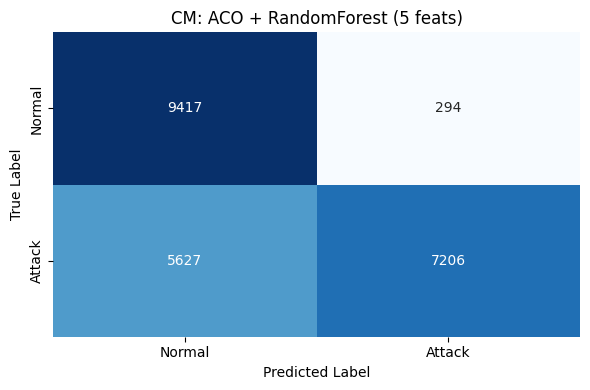


  Classifiers Eval (PSO):   0%|          | 0/1 [00:00<?, ?it/s]


Results for PSO + RandomForest:
  Number of Features: 40
  Accuracy: 0.7794
  ROC AUC: 0.9610
  False Positive Rate (FPR): 0.0347
  False Negative Rate (FNR): 0.3613


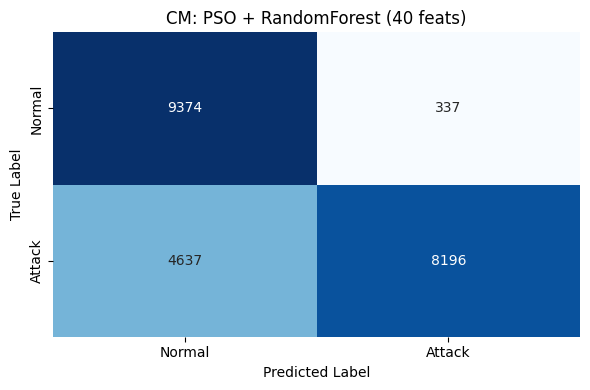


  Classifiers Eval (ABC):   0%|          | 0/1 [00:00<?, ?it/s]


Results for ABC + RandomForest:
  Number of Features: 49
  Accuracy: 0.7748
  ROC AUC: 0.9506
  False Positive Rate (FPR): 0.0290
  False Negative Rate (FNR): 0.3736


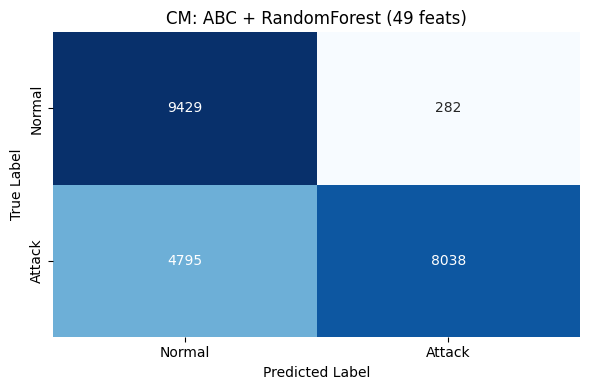


  Classifiers Eval (MWPA):   0%|          | 0/1 [00:00<?, ?it/s]


Results for MWPA + RandomForest:
  Number of Features: 9
  Accuracy: 0.7469
  ROC AUC: 0.8658
  False Positive Rate (FPR): 0.0423
  False Negative Rate (FNR): 0.4126


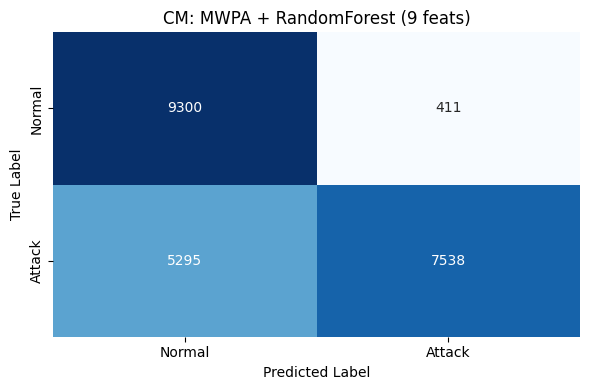


  Classifiers Eval (Hybrid):   0%|          | 0/1 [00:00<?, ?it/s]


Results for Hybrid + RandomForest:
  Number of Features: 55
  Accuracy: 0.7910
  ROC AUC: 0.9439
  False Positive Rate (FPR): 0.0289
  False Negative Rate (FNR): 0.3453


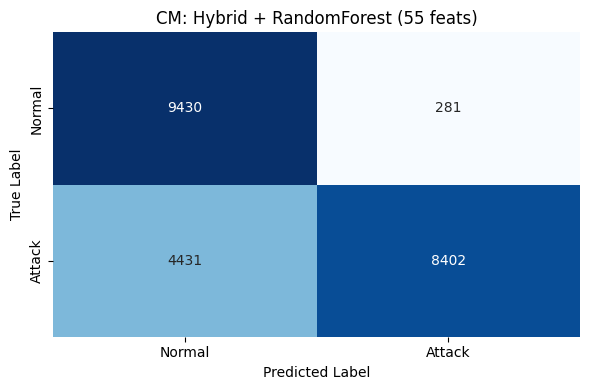


FS Methods Evaluation: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]      


--- Summary of Test Set Evaluation Results ---


,FS Method,Classifier,Num Features,Accuracy,FPR,FNR,ROC AUC,Precision (Attack),Recall (Attack),F1-Score (Attack),FS Time (s),Train Time (s),Status
4,Hybrid,RandomForest,55,0.7910,0.0289,0.3453,0.9439,0.9676,0.6547,0.7810,2151.31,375.24,Success
1,PSO,RandomForest,40,0.7794,0.0347,0.3613,0.9610,0.9605,0.6387,0.7672,803.40,287.50,Success
2,ABC,RandomForest,49,0.7748,0.0290,0.3736,0.9506,0.9661,0.6264,0.7600,753.12,332.09,Success
3,MWPA,RandomForest,9,0.7469,0.0423,0.4126,0.8658,0.9483,0.5874,0.7254,488.20,188.95,Success
0,ACO,RandomForest,5,0.7374,0.0303,0.4385,0.8669,0.9608,0.5615,0.7088,111.13,163.76,Success



Best Hybrid (RandomForest) result from table: Accuracy=0.7910, FPR=0.0289 (Num Features: 55)
Best Individual method (RandomForest) result (by Acc then FPR): Accuracy=0.7794, FPR=0.0347 (FS Method: PSO, Num Features: 40)

CONCLUSION (RandomForest Specific): Hybrid method achieved higher accuracy AND lower FPR than the best individual method.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
import seaborn as sns # For plotting confusion matrix
import traceback # For detailed error messages
from IPython.display import display, HTML # For displaying styled DataFrame
from functools import partial # For passing arguments to style function


print("\n--- Starting Final Model Evaluation on Test Set ---")
final_evaluation_results = {}


models_available_for_eval = 'final_models' in globals() and final_models and \
                            any(hasattr(model, 'predict') # Check for predict method instead of specific type for more flexibility
                                for fs_method_models in final_models.values()
                                for model in fs_method_models.values())
test_data_available_for_eval = 'X_test_p' in globals() and 'y_test' in globals() and \
                               X_test_p.shape[0] > 0 and y_test.shape[0] > 0 and \
                               'feature_selection_results' in globals()


if models_available_for_eval and test_data_available_for_eval:
    # Loop over each feature selection method
    for fs_method_name, clf_model_dict in tqdm(final_models.items(), desc="FS Methods Evaluation"):
        fs_results_for_method_outer_loop = feature_selection_results.get(fs_method_name, {}) # Renamed for clarity
        selected_mask = fs_results_for_method_outer_loop.get('selected_mask')

        final_evaluation_results[fs_method_name] = {}

        # Validate selected_mask
        if selected_mask is None or not isinstance(selected_mask, np.ndarray) or selected_mask.size == 0:
            print(f"  Skipping {fs_method_name}: Invalid or missing feature selection mask.")
            final_evaluation_results[fs_method_name] = {
                clf_name: "Invalid/Missing FS Mask" for clf_name in clf_model_dict.keys()
            }
            continue
        
        num_selected_features = int(np.sum(selected_mask))
        if num_selected_features == 0:
            print(f"  Skipping {fs_method_name}: No features were selected by this method.")
            final_evaluation_results[fs_method_name] = {
                clf_name: "No Features Selected" for clf_name in clf_model_dict.keys()
            }
            continue

        # Prepare test set with selected features
        if selected_mask.shape[0] != X_test_p.shape[1]:
            print(f"  Skipping {fs_method_name}: Mask shape {selected_mask.shape} incompatible with X_test_p columns {X_test_p.shape[1]}.")
            final_evaluation_results[fs_method_name] = {
                clf_name: "FS Mask Shape Mismatch" for clf_name in clf_model_dict.keys()
            }
            continue
            
        feature_indices = np.where(selected_mask == 1)[0]
        X_test_selected = X_test_p[:, feature_indices]

        if X_test_selected.shape[1] == 0 and num_selected_features > 0 : 
             print(f"  Warning for {fs_method_name}: num_selected_features is {num_selected_features} but X_test_selected has 0 columns.")
        
        # Evaluate each classifier trained for this FS method
        for clf_name, model_object in tqdm(
            clf_model_dict.items(),
            desc=f"  Classifiers Eval ({fs_method_name})",
            leave=False
        ):
            if not hasattr(model_object, 'predict'): 
                final_evaluation_results[fs_method_name][clf_name] = model_object 
                print(f"  Skipping evaluation for {clf_name} under {fs_method_name}: Model not available ({model_object}).")
                continue

            try:
                y_pred_test = model_object.predict(X_test_selected)
                y_proba_test = model_object.predict_proba(X_test_selected)[:, 1] 

                accuracy = accuracy_score(y_test, y_pred_test)
                roc_auc = roc_auc_score(y_test, y_proba_test)
                
                cm = confusion_matrix(y_test, y_pred_test)
                # Using original logic for cm.ravel() as requested to not alter this part
                tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0,0,0,0) 
                
                fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0 
                fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0 

                class_report_dict = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
                
                final_evaluation_results[fs_method_name][clf_name] = {
                    'accuracy': accuracy,
                    'roc_auc': roc_auc,
                    'fpr': fpr,
                    'fnr': fnr,
                    'confusion_matrix': cm.tolist(), 
                    'classification_report': class_report_dict,
                    'num_features': num_selected_features, # num_selected_features from current FS method
                    'y_pred': y_pred_test.tolist(), 
                    'y_proba': y_proba_test.tolist() 
                }

                if True: # Set to False to reduce console output during evaluation
                    print(f"\nResults for {fs_method_name} + {clf_name}:")
                    print(f"  Number of Features: {num_selected_features}")
                    print(f"  Accuracy: {accuracy:.4f}")
                    print(f"  ROC AUC: {roc_auc:.4f}")
                    print(f"  False Positive Rate (FPR): {fpr:.4f}")
                    print(f"  False Negative Rate (FNR): {fnr:.4f}")

                    plt.figure(figsize=(6, 4))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
                    plt.xlabel('Predicted Label')
                    plt.ylabel('True Label')
                    plt.title(f'CM: {fs_method_name} + {clf_name} ({num_selected_features} feats)')
                    plt.tight_layout()
                    plt.show()
            except Exception as e:
                print(f"  Error evaluating {clf_name} for {fs_method_name}: {e}")
                print(traceback.format_exc()) # Print full traceback for debugging
                final_evaluation_results[fs_method_name][clf_name] = f"Evaluation Failed: {str(e)}" # Store error as string
    
    # --- Summary Table ---
    print("\n--- Summary of Test Set Evaluation Results ---")
    summary_list = []
    for fs_name_key, clf_results_dict in final_evaluation_results.items():
        # Correctly get fs_time and num_features for the current fs_name_key
        current_fs_method_info = feature_selection_results.get(fs_name_key, {})
        fs_time = current_fs_method_info.get('time', np.nan)
        # Default num_features from feature_selection_results, can be overridden by metrics_dict if available
        num_features_from_fs_info = current_fs_method_info.get('num_features', 0)

        for clf_name_key, metrics_dict in clf_results_dict.items():
            row = {
                'FS Method': fs_name_key,
                'Classifier': clf_name_key,
            }
            if isinstance(metrics_dict, str): 
                row.update({
                    'Num Features': num_features_from_fs_info, # Use default if metrics_dict is error string
                    'Status': metrics_dict, 'Accuracy': np.nan, 'FPR': np.nan, 'FNR': np.nan, 'ROC AUC': np.nan,
                    'Precision (Attack)': np.nan, 'Recall (Attack)': np.nan, 'F1-Score (Attack)': np.nan
                })
            else:
                # metrics_dict.get('num_features',...) will correctly use the one stored during evaluation
                # which should match num_features_from_fs_info for that fs_method_name
                attack_report = metrics_dict.get('classification_report', {}).get('1', {}) # '1' for positive class (Attack)
                row.update({
                    'Num Features': metrics_dict.get('num_features', num_features_from_fs_info),
                    'Status': 'Success',
                    'Accuracy': metrics_dict.get('accuracy', np.nan),
                    'FPR': metrics_dict.get('fpr', np.nan),
                    'FNR': metrics_dict.get('fnr', np.nan),
                    'ROC AUC': metrics_dict.get('roc_auc', np.nan),
                    'Precision (Attack)': attack_report.get('precision', np.nan),
                    'Recall (Attack)': attack_report.get('recall', np.nan),
                    'F1-Score (Attack)': attack_report.get('f1-score', np.nan)
                })
            
            model_train_time = final_model_training_times.get(fs_name_key, {}).get(clf_name_key, np.nan)
            row['FS Time (s)'] = fs_time
            row['Train Time (s)'] = model_train_time
            summary_list.append(row)

    summary_df = pd.DataFrame(summary_list)
    column_order = [
        'FS Method', 'Classifier', 'Num Features', 'Accuracy', 'FPR', 'FNR', 'ROC AUC',
        'Precision (Attack)', 'Recall (Attack)', 'F1-Score (Attack)',
        'FS Time (s)', 'Train Time (s)', 'Status'
    ]
    # Ensure all columns exist, add missing ones with NaNs if necessary
    for col in column_order:
        if col not in summary_df.columns:
            summary_df[col] = np.nan
            
    summary_df = summary_df[column_order]
    # Sort by Classifier first, then by key metrics
    summary_df = summary_df.sort_values(by=['Classifier','Accuracy', 'FPR'], ascending=[True, False, True])
    
    # --- Styling the DataFrame ---
    metrics_higher_better = ['Accuracy', 'ROC AUC', 'Precision (Attack)', 'Recall (Attack)', 'F1-Score (Attack)']
    metrics_lower_better = ['FPR', 'FNR', 'Num Features', 'FS Time (s)', 'Train Time (s)']

    def style_hybrid_comparison(row, full_df, higher_better_cols, lower_better_cols):
        styles = [''] * len(row.index) # Default: no style
        win_style = 'font-weight: bold; background-color: #90EE90;' # lightgreen for emphasis

        if row['FS Method'] == 'Hybrid' and row['Status'] == 'Success':
            clf = row['Classifier']
            
            # Get all successful, non-Hybrid rows for the same classifier
            comparison_group = full_df[
                (full_df['Classifier'] == clf) &
                (full_df['FS Method'] != 'Hybrid') &
                (full_df['Status'] == 'Success')
            ]

            for i, col_name in enumerate(row.index):
                if pd.isna(row[col_name]): # Skip styling for NaN values in the Hybrid row
                    continue

                is_better = False
                if comparison_group.empty: # Hybrid is the only successful one for this classifier
                    if col_name in higher_better_cols or col_name in lower_better_cols:
                        is_better = True # Highlight its metrics as "best by default"
                else:
                    if col_name in higher_better_cols:
                        # Max of comparison group for this metric (ignoring NaNs in comparison)
                        max_other = comparison_group[col_name].max() 
                        if pd.notna(max_other):
                            if row[col_name] > max_other:
                                is_better = True
                        elif pd.notna(row[col_name]): # Hybrid has value, others are all NaN for this metric
                            is_better = True 
                    elif col_name in lower_better_cols:
                        min_other = comparison_group[col_name].min()
                        if pd.notna(min_other):
                            if row[col_name] < min_other:
                                is_better = True
                        elif pd.notna(row[col_name]): # Hybrid has value, others are all NaN for this metric
                            is_better = True
                
                if is_better:
                    styles[i] = win_style
        return pd.Series(styles, index=row.index)

    # Apply formatting and styling
    float_format_cols = {
        'Accuracy': "{:.4f}", 'FPR': "{:.4f}", 'FNR': "{:.4f}", 'ROC AUC': "{:.4f}",
        'Precision (Attack)': "{:.4f}", 'Recall (Attack)': "{:.4f}", 'F1-Score (Attack)': "{:.4f}",
        'FS Time (s)': "{:.2f}", 'Train Time (s)': "{:.2f}"
    }
    
    valid_format_cols = {k: v for k, v in float_format_cols.items() if k in summary_df.columns}

    if not summary_df.empty:
        # Use functools.partial to pass additional arguments to the style function
        style_func_with_args = partial(style_hybrid_comparison, 
                                       full_df=summary_df, 
                                       higher_better_cols=metrics_higher_better, 
                                       lower_better_cols=metrics_lower_better)
        
        styled_df = summary_df.style.apply(style_func_with_args, axis=1) \
                                    .format(valid_format_cols) \
                                    .set_table_styles([
                                        {'selector': 'th', 'props': [('text-align', 'left'), ('font-size', '10pt'), ('padding', '4px 8px')]},
                                        {'selector': 'td', 'props': [('text-align', 'left'), ('font-size', '9pt'), ('padding', '4px 8px'), ('border-bottom', '1px solid #ddd')]},
                                        {'selector': 'tr:hover td', 'props': [('background-color', '#f2f2f2')]} # Hover effect
                                     ]) \
                                    .set_caption("<h3 style='text-align:left; margin-bottom:10px; font-family: Arial, sans-serif;'>Model Evaluation Summary (Hybrid Performance Highlighted)</h3>") \
                                    .highlight_null()
        
        display(styled_df)
        # To save to HTML file:
        # html_output = styled_df.to_html()
        # with open("styled_summary_report.html", "w") as f:
        #     f.write(html_output)
        # print("\nStyled summary report saved to styled_summary_report.html")
    else:
        print("Summary DataFrame is empty. No table to display.")
    
    # The table styling above provides the broader, all-metric emphasis.
    if not summary_df.empty and 'Hybrid' in summary_df['FS Method'].values:
        # The rest of your original conclusion logic from here...
        hybrid_rf_results = summary_df[(summary_df['FS Method'] == 'Hybrid') & (summary_df['Classifier'] == 'RandomForest') & (summary_df['Status'] == 'Success')]
        if not hybrid_rf_results.empty:
            # Find the best Hybrid RF row (highest accuracy, then lowest FPR)
            hybrid_rf_results_sorted = hybrid_rf_results.sort_values(by=['Accuracy', 'FPR'], ascending=[False, True])
            best_hybrid_rf_row = hybrid_rf_results_sorted.iloc[0]
            best_hybrid_acc = best_hybrid_rf_row['Accuracy']
            best_hybrid_fpr = best_hybrid_rf_row['FPR']
            print(f"\nBest Hybrid (RandomForest) result from table: Accuracy={best_hybrid_acc:.4f}, FPR={best_hybrid_fpr:.4f} (Num Features: {best_hybrid_rf_row['Num Features']})")

            individual_methods_df = summary_df[~summary_df['FS Method'].isin(['Hybrid', 'No FS']) & (summary_df['Classifier'] == 'RandomForest') & (summary_df['Status'] == 'Success')]
            if not individual_methods_df.empty:
                best_individual_sorted = individual_methods_df.sort_values(by=['Accuracy', 'FPR'], ascending=[False, True])
                best_individual_row = best_individual_sorted.iloc[0]
                best_individual_acc = best_individual_row['Accuracy']
                best_individual_fpr = best_individual_row['FPR'] # FPR of the best individual method by Accuracy
                print(f"Best Individual method (RandomForest) result (by Acc then FPR): Accuracy={best_individual_acc:.4f}, FPR={best_individual_fpr:.4f} (FS Method: {best_individual_row['FS Method']}, Num Features: {best_individual_row['Num Features']})")

                # Original comparison logic
                if pd.notna(best_hybrid_acc) and pd.notna(best_hybrid_fpr) and \
                   pd.notna(best_individual_acc) and pd.notna(best_individual_fpr):
                    if best_hybrid_acc > best_individual_acc and best_hybrid_fpr < best_individual_fpr:
                        print("\nCONCLUSION (RandomForest Specific): Hybrid method achieved higher accuracy AND lower FPR than the best individual method.")
                    elif best_hybrid_acc > best_individual_acc:
                        print("\nCONCLUSION (RandomForest Specific): Hybrid method achieved higher accuracy than the best individual method.")
                    elif best_hybrid_fpr < best_individual_fpr : # Consider if accuracy is comparable or not a primary concern for this specific FPR comparison
                        print("\nCONCLUSION (RandomForest Specific): Hybrid method achieved lower FPR than the best individual method.")
                    elif best_hybrid_acc == best_individual_acc and best_hybrid_fpr == best_individual_fpr:
                         print("\nCONCLUSION (RandomForest Specific): Hybrid method performed comparably to the best individual method on Accuracy and FPR.")
                    else:
                        print("\nCONCLUSION (RandomForest Specific): Hybrid method did not clearly outperform the best individual method on both accuracy and FPR based on this specific comparison logic.")
                else:
                    print("\nCONCLUSION (RandomForest Specific): Could not make a definitive comparison due to missing values in key metrics for Hybrid or best individual.")
            else:
                print("\nNo successful 'RandomForest' individual method results to compare against Hybrid for the textual conclusion.")
        else:
            print("\nHybrid (RandomForest) method did not produce successful results for the textual comparison.")
    elif not summary_df.empty:
         print("\nHybrid (RandomForest) results are missing or no successful runs; cannot make the specific textual conclusion for RandomForest.")
    

else:
    print("\nSkipping final model evaluation: Trained models or test data are not available/valid.")
    summary_df = pd.DataFrame() 
    if 'display' in globals() and 'HTML' in globals():
        display(HTML("<p>No evaluation data to display as models or test data were not available/valid.</p>"))



### 9. Implement Hybrid Swarm Optimizer for Benchmarks
#### Implement a hybrid ACO+PSO+ABC+MWPA algorithm for continuous optimization benchmark functions.

- This class `HybridSwarmOptimizer` manages the population and the iteration process for continuous variables.
- It minimizes the objective function.
- The `update_agents` method implements the hybridization logic, attempting to combine the update rules for continuous space. This implementation uses a probabilistic approach where each agent applies one of the component-inspired updates (ACO, PSO+MWPA, ABC).

**Note:** This is a *plausible interpretation* of how these algorithms could be hybridized for continuous optimization, inspired by the abstract's equation. Your specific novel algorithm might differ. You should replace the logic inside `initialize_agents` and `update_agents` with your precise implementation if needed.

In [ ]:
# 9. Implement hybrid swarm optimizer for benchmarks
import numpy as np
import time

# ----------------------------
# Benchmark Functions (to minimize) - Standard definitions
# ----------------------------

def sphere_func(x_vector):
    """Sphere function: f(x) = sum(x_i^2). Global minimum 0 at x = [0, ..., 0]."""
    return np.sum(np.square(x_vector))

def rastrigin_func(x_vector):
    """Rastrigin function: f(x) = 10*n + sum(x_i^2 - 10*cos(2*pi*x_i)). Min 0 at x=[0,...,0]."""
    n_dim = x_vector.size
    return 10 * n_dim + np.sum(x_vector**2 - 10 * np.cos(2 * np.pi * x_vector))

def rosenbrock_func(x_vector):
    """Rosenbrock function: f(x) = sum(100*(x_{i+1} - x_i^2)^2 + (x_i - 1)^2). Min 0 at x=[1,...,1]."""
    if x_vector.size < 2:
        return np.sum((x_vector - 1)**2) # Simplified for 1D
    return np.sum(100.0 * (x_vector[1:] - x_vector[:-1]**2.0)**2.0 + (x_vector[:-1] - 1)**2.0)

# ----------------------------
# Example Bounds for Benchmarks
# ----------------------------
# n_dimensions_benchmark = 10 # Define this before running, e.g., in the next cell or globally
# bounds_sphere      = np.array([[-5.12,  5.12]] * n_dimensions_benchmark)
# bounds_rastrigin   = np.array([[-5.12,  5.12]] * n_dimensions_benchmark)
# bounds_rosenbrock  = np.array([[-2.048, 2.048]] * n_dimensions_benchmark) # Rosenbrock often uses [-5, 10] or similar

# ----------------------------
# Hybrid Swarm Optimizer Class for Continuous Benchmarks
# ----------------------------

class HybridContinuousOptimizer:
    def __init__(self,
                 objective_function,
                 bounds_matrix, # Expects numpy array of shape (n_dimensions, 2)
                 n_agents=30,
                 max_iterations=100,
                 # PSO parameters
                 pso_w_range=(0.4, 0.9), pso_c1=1.5, pso_c2=1.5,
                 # DE parameters (Differential Evolution, a good alternative/addition for continuous)
                 de_cr=0.9, de_f=0.5, # Crossover rate, Differential weight
                 # Simple random walk / local search component
                 local_search_std_dev_factor=0.01, # Factor of domain range for local search
                 # Operator probabilities [PSO, DE, LocalSearch]
                 operator_probabilities=None,
                 adaptive_lr=0.1, # Learning rate for operator probabilities
                 verbose=False):
        
        self.objective_func = objective_function
        self.bounds = bounds_matrix 
        self.n_dimensions = self.bounds.shape[0]
        self.domain_range = self.bounds[:, 1] - self.bounds[:, 0]

        self.n_agents = n_agents
        self.max_iter = max_iterations
        self.verbose = verbose

        # PSO params
        self.pso_w_min, self.pso_w_max = pso_w_range
        self.pso_c1, self.pso_c2 = pso_c1, pso_c2
        
        # DE params
        self.de_cr, self.de_f = de_cr, de_f

        # Local Search param
        self.local_search_std_dev = local_search_std_dev_factor * self.domain_range

        # Operators & Adaptive Selection
        self.operators = ['PSO', 'DE', 'LocalSearch']
        if operator_probabilities is None or len(operator_probabilities) != len(self.operators):
            self.op_probs = np.full(len(self.operators), 1.0 / len(self.operators))
        else:
            self.op_probs = np.array(operator_probabilities, dtype=float)
        self.op_rewards = np.zeros(len(self.operators))
        self.op_counts = np.zeros(len(self.operators)) + 1e-6 # Avoid division by zero
        self.adaptive_lr = adaptive_lr

        # Agent states
        self.positions = np.zeros((self.n_agents, self.n_dimensions))
        self.velocities = np.zeros_like(self.positions) # For PSO
        self.fitness_values = np.full(self.n_agents, np.inf)

        # Personal bests (for PSO-like behavior if needed, or general agent memory)
        self.pbest_positions = np.zeros_like(self.positions)
        self.pbest_fitness = np.full(self.n_agents, np.inf)

        # Global best
        self.gbest_position = np.zeros(self.n_dimensions)
        self.gbest_fitness = np.inf
        
        self.convergence_history = []
        self.computation_time = 0.0

        if self.verbose:
            print(f"HybridContinuousOptimizer initialized for '{objective_function.__name__}' with {self.n_dimensions} dimensions.")
            print(f"Operators: {self.operators}, Initial Probs: {self.op_probs}")

    def _initialize_agents(self):
        # Initialize positions uniformly within bounds
        for i in range(self.n_dimensions):
            self.positions[:, i] = np.random.uniform(self.bounds[i, 0], self.bounds[i, 1], self.n_agents)
        
        self.velocities = np.random.uniform(-0.1 * self.domain_range, 0.1 * self.domain_range, 
                                            (self.n_agents, self.n_dimensions)) # Scaled initial velocities

        for i in range(self.n_agents):
            self.fitness_values[i] = self.objective_func(self.positions[i])
            if self.fitness_values[i] < self.pbest_fitness[i]:
                self.pbest_fitness[i] = self.fitness_values[i]
                self.pbest_positions[i] = self.positions[i].copy()
            if self.fitness_values[i] < self.gbest_fitness:
                self.gbest_fitness = self.fitness_values[i]
                self.gbest_position = self.positions[i].copy()
        self.convergence_history.append(self.gbest_fitness)

    def _select_operator(self):
        idx = np.random.choice(len(self.operators), p=self.op_probs)
        return idx, self.operators[idx]

    def _update_operator_probs(self, op_idx, reward):
        self.op_rewards[op_idx] += reward
        self.op_counts[op_idx] += 1
        avg_rewards = self.op_rewards / self.op_counts
        # Softmax-like update for probabilities
        exp_rewards = np.exp(self.adaptive_lr * (avg_rewards - np.max(avg_rewards))) # Stability
        self.op_probs = exp_rewards / np.sum(exp_rewards)


    def _apply_operator_and_evaluate(self, agent_idx, op_name, iteration):
        current_pos = self.positions[agent_idx].copy()
        candidate_pos = current_pos.copy()
        
        pso_w = self.pso_w_max - (self.pso_w_max - self.pso_w_min) * (iteration / self.max_iter)

        if op_name == 'PSO':
            r1, r2 = np.random.rand(self.n_dimensions), np.random.rand(self.n_dimensions)
            self.velocities[agent_idx] = (pso_w * self.velocities[agent_idx] +
                                          self.pso_c1 * r1 * (self.pbest_positions[agent_idx] - current_pos) +
                                          self.pso_c2 * r2 * (self.gbest_position - current_pos))
            candidate_pos = current_pos + self.velocities[agent_idx]

        elif op_name == 'DE': # Differential Evolution (rand/1/bin variant)
            idxs = [idx for idx in range(self.n_agents) if idx != agent_idx]
            a, b, c = self.positions[np.random.choice(idxs, 3, replace=False)]
            mutant_pos = a + self.de_f * (b - c)
            # Binomial Crossover
            cross_points = np.random.rand(self.n_dimensions) < self.de_cr
            if not np.any(cross_points): # Ensure at least one point from mutant
                cross_points[np.random.randint(0, self.n_dimensions)] = True
            candidate_pos = np.where(cross_points, mutant_pos, current_pos)

        elif op_name == 'LocalSearch': # Simple Gaussian Perturbation
            perturbation = np.random.normal(0, self.local_search_std_dev, self.n_dimensions)
            candidate_pos = current_pos + perturbation
        
        # Boundary enforcement (clipping)
        candidate_pos = np.clip(candidate_pos, self.bounds[:, 0], self.bounds[:, 1])
        
        candidate_fitness = self.objective_func(candidate_pos)
        original_fitness = self.fitness_values[agent_idx]
        reward = 0

        if candidate_fitness < self.fitness_values[agent_idx]:
            self.positions[agent_idx] = candidate_pos
            self.fitness_values[agent_idx] = candidate_fitness
            reward = original_fitness - candidate_fitness # Positive reward for improvement

            if candidate_fitness < self.pbest_fitness[agent_idx]:
                self.pbest_fitness[agent_idx] = candidate_fitness
                self.pbest_positions[agent_idx] = candidate_pos.copy()
            
            if candidate_fitness < self.gbest_fitness:
                self.gbest_fitness = candidate_fitness
                self.gbest_position = candidate_pos.copy()
        return reward

    def run(self, patience=15):
        start_time = time.time()
        self._initialize_agents()
        
        stall_iterations = 0
        last_best_fitness_val = self.gbest_fitness

        for iteration in range(self.max_iter):
            for i in range(self.n_agents):
                op_idx, op_name = self._select_operator()
                reward = self._apply_operator_and_evaluate(i, op_name, iteration)
                self._update_operator_probs(op_idx, reward)
            
            self.convergence_history.append(self.gbest_fitness)
            
            if self.verbose and (iteration % 10 == 0 or iteration == self.max_iter - 1) :
                print(f"Iter {iteration+1}/{self.max_iter}: Best Fitness = {self.gbest_fitness:.4e}, "
                      f"Op Probs: {[f'{p:.2f}' for p in self.op_probs]}")

            # Early stopping
            if self.gbest_fitness < last_best_fitness_val:
                last_best_fitness_val = self.gbest_fitness
                stall_iterations = 0
            else:
                stall_iterations += 1
            
            if stall_iterations >= patience:
                if self.verbose: print(f"Early stopping at iteration {iteration+1} due to stagnation.")
                break
                
        self.computation_time = time.time() - start_time
        if self.verbose:
            print(f"Optimization finished in {self.computation_time:.2f}s. Best fitness: {self.gbest_fitness:.4e}")
        return self.gbest_position, self.gbest_fitness, self.convergence_history, self.computation_time

### 10. Benchmark Function Analysis

#### Evaluate the performance of the hybrid swarm intelligence algorithm on standard optimization benchmark functions like Sphere, Rastrigin, and Rosenbrock. This helps assess its global search and convergence capabilities independently of the feature selection problem.

#### **Concept:**
 - Define the benchmark functions (mathematical functions with known global minima).
 - Run the hybrid algorithm (`HybridSwarmOptimizer`) on each benchmark function and track the convergence towards the known minimum.
 - Measure computational efficiency.


--- Running Benchmark Function Analysis (HybridContinuousOptimizer, D=10) ---


Running Benchmarks:   0%|          | 0/3 [00:00<?, ?it/s]


Optimizing Sphere function...


Running Benchmarks:  33%|███▎      | 1/3 [00:02<00:05,  2.65s/it]

  Sphere completed. Avg Best Fitness: 6.8835e-06 (Std: 4.07e-06), Overall Min Fitness: 1.2068e-06, Avg Time: 0.88s

Optimizing Rastrigin function...


Running Benchmarks:  67%|██████▋   | 2/3 [00:03<00:01,  1.69s/it]

  Rastrigin completed. Avg Best Fitness: 4.5558e+01 (Std: 1.03e+01), Overall Min Fitness: 3.5231e+01, Avg Time: 0.34s

Optimizing Rosenbrock function...


Running Benchmarks: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

  Rosenbrock completed. Avg Best Fitness: 3.4486e+02 (Std: 1.91e+02), Overall Min Fitness: 1.7540e+02, Avg Time: 0.11s

--- Benchmark Function Analysis Complete ---


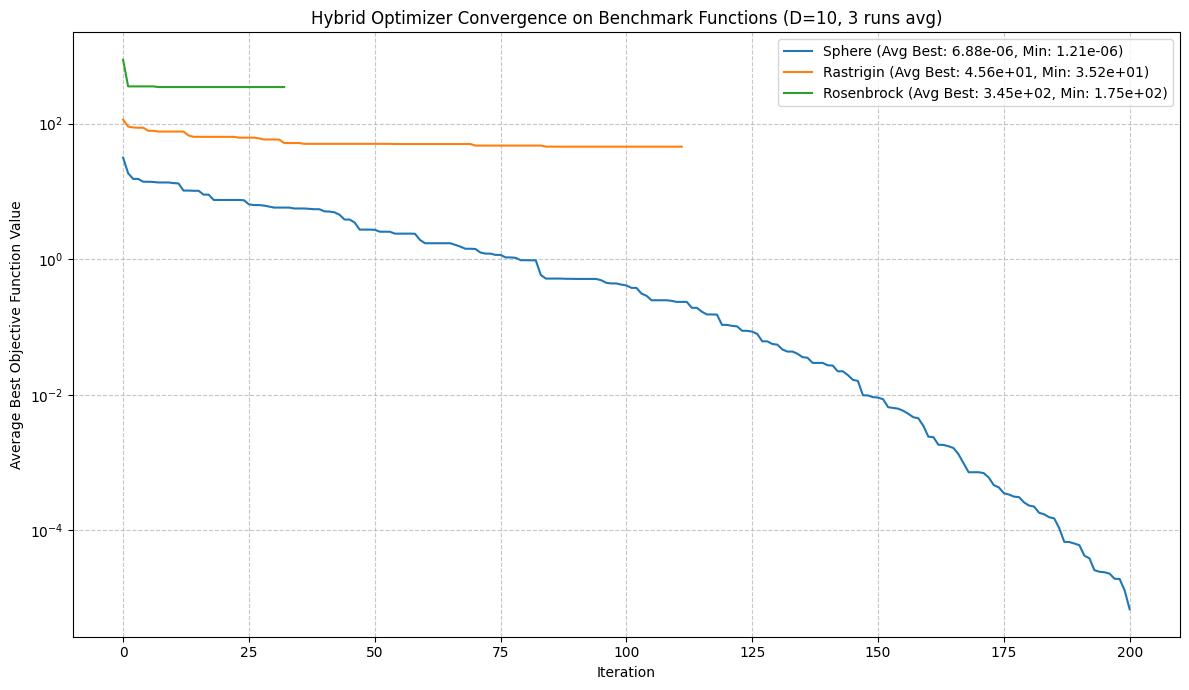


Benchmark Summary (HybridContinuousOptimizer):
  Function  Dimensions  Known Minimum Avg Best Fitness Std Best Fitness Min Best Fitness Avg Time (s)  Status
    Sphere          10            0.0       6.8835e-06         4.07e-06       1.2068e-06         0.88 Success
 Rastrigin          10            0.0       4.5558e+01         1.03e+01       3.5231e+01         0.34 Success
Rosenbrock          10            0.0       3.4486e+02         1.91e+02       1.7540e+02         0.11 Success


In [23]:
# 10. Benchmark function analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Define Benchmark Problem Settings ---
n_dimensions_benchmark = 10 # Standard dimension for testing

# Bounds for each function (as numpy arrays)
bounds_sphere = np.array([[-5.12, 5.12]] * n_dimensions_benchmark)
bounds_rastrigin = np.array([[-5.12, 5.12]] * n_dimensions_benchmark)
# Rosenbrock is often tested in [-5, 10] or [-2.048, 2.048]. Using the latter.
bounds_rosenbrock = np.array([[-2.048, 2.048]] * n_dimensions_benchmark)

benchmark_problems = {
    'Sphere': {'func': sphere_func, 'bounds': bounds_sphere, 'known_min': 0.0},
    'Rastrigin': {'func': rastrigin_func, 'bounds': bounds_rastrigin, 'known_min': 0.0},
    'Rosenbrock': {'func': rosenbrock_func, 'bounds': bounds_rosenbrock, 'known_min': 0.0}
}

benchmark_run_results = {} # Stores results for each benchmark function

if n_dimensions_benchmark > 0:
    print(f"\n--- Running Benchmark Function Analysis (HybridContinuousOptimizer, D={n_dimensions_benchmark}) ---")

    # Common parameters for the HybridContinuousOptimizer runs
    optimizer_common_params = {
        'n_agents': 50,        # Number of agents in the swarm
        'max_iterations': 200, # Max iterations per run (increased for better convergence)
        # Operator-specific params (can be tuned per benchmark if needed)
        'pso_w_range': (0.4, 0.9), 'pso_c1': 1.5, 'pso_c2': 1.5,
        'de_cr': 0.9, 'de_f': 0.6,
        'local_search_std_dev_factor': 0.01,
        'operator_probabilities': [0.4, 0.4, 0.2], # Initial bias: PSO, DE, LocalSearch
        'adaptive_lr': 0.1,
        'verbose': False # Set to True for detailed output from optimizer, False for cleaner tqdm loop
    }
    
    num_runs_per_benchmark = 3 # Perform multiple runs for robustness (e.g., 5-10 for actual analysis)

    for problem_name, config in tqdm(benchmark_problems.items(), desc="Running Benchmarks"):
        print(f"\nOptimizing {problem_name} function...")
        
        all_runs_best_fitness = []
        all_runs_histories = []
        all_runs_times = []

        for run_num in range(num_runs_per_benchmark):
            if optimizer_common_params.get('verbose', False): # only print if optimizer itself is verbose
                print(f"  Run {run_num + 1}/{num_runs_per_benchmark} for {problem_name}...")
            
            try:
                optimizer = HybridContinuousOptimizer(
                    objective_function=config['func'],
                    bounds_matrix=config['bounds'],
                    **optimizer_common_params
                )
                # Run with patience for early stopping
                best_solution, best_fitness, history, time_taken = optimizer.run(patience=25) 
                
                all_runs_best_fitness.append(best_fitness)
                all_runs_histories.append(history)
                all_runs_times.append(time_taken)

            except Exception as e:
                print(f"  Error during run {run_num + 1} for {problem_name}: {e}")
                print(traceback.format_exc())
                all_runs_best_fitness.append(np.inf) # Error case
                all_runs_histories.append([np.inf] * optimizer_common_params['max_iterations'])
                all_runs_times.append(0)
        
        # Aggregate results from multiple runs
        avg_best_fitness = np.mean(all_runs_best_fitness)
        std_best_fitness = np.std(all_runs_best_fitness)
        min_best_fitness = np.min(all_runs_best_fitness) # Best fitness found across all runs
        avg_time = np.mean(all_runs_times)
        
        # For plotting, average the convergence histories (pad if lengths differ due to early stopping)
        max_len_history = max(len(h) for h in all_runs_histories)
        padded_histories = [np.pad(h, (0, max_len_history - len(h)), 'edge') for h in all_runs_histories]
        avg_history = np.mean(np.array(padded_histories), axis=0)

        benchmark_run_results[problem_name] = {
            'avg_best_fitness': avg_best_fitness,
            'std_best_fitness': std_best_fitness,
            'min_best_fitness': min_best_fitness, # Overall best
            'avg_time_s': avg_time,
            'avg_convergence_history': avg_history.tolist(), # Store as list
            'known_minimum': config['known_min'],
            'status': 'Success' if np.isfinite(avg_best_fitness) else 'Failed'
        }
        print(f"  {problem_name} completed. Avg Best Fitness: {avg_best_fitness:.4e} (Std: {std_best_fitness:.2e}), "
              f"Overall Min Fitness: {min_best_fitness:.4e}, Avg Time: {avg_time:.2f}s")

    print("\n--- Benchmark Function Analysis Complete ---")

    # Plot average convergence curves
    plt.figure(figsize=(12, 7))
    for problem_name, results in benchmark_run_results.items():
        if results['avg_convergence_history']:
            plt.plot(results['avg_convergence_history'], 
                     label=f"{problem_name} (Avg Best: {results['avg_best_fitness']:.2e}, Min: {results['min_best_fitness']:.2e})")
    
    plt.xlabel("Iteration")
    plt.ylabel("Average Best Objective Function Value")
    plt.title(f"Hybrid Optimizer Convergence on Benchmark Functions (D={n_dimensions_benchmark}, {num_runs_per_benchmark} runs avg)")
    plt.yscale('log') # Log scale is common for benchmark functions
    plt.legend(loc='upper right')
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Summarize benchmark results in a table
    print("\nBenchmark Summary (HybridContinuousOptimizer):")
    summary_data_list = []
    for problem_name, res_dict in benchmark_run_results.items():
        summary_data_list.append({
            'Function': problem_name,
            'Dimensions': n_dimensions_benchmark,
            'Known Minimum': res_dict.get('known_minimum', 'N/A'),
            'Avg Best Fitness': f"{res_dict['avg_best_fitness']:.4e}",
            'Std Best Fitness': f"{res_dict['std_best_fitness']:.2e}",
            'Min Best Fitness': f"{res_dict['min_best_fitness']:.4e}", # Overall best from all runs
            'Avg Time (s)': f"{res_dict['avg_time_s']:.2f}",
            'Status': res_dict.get('status', 'N/A')
        })
    benchmark_summary_df = pd.DataFrame(summary_data_list)
    print(benchmark_summary_df.to_string(index=False))

else:
    print("\nSkipping benchmark function analysis: 'n_dimensions_benchmark' is not defined or is zero.")
    benchmark_run_results = {} # Ensure it exists
    benchmark_summary_df = pd.DataFrame()

### 11. Tools and Libraries

#### The following libraries were used or are intended for use in this project:

 - **Pandas:** Data loading and manipulation.
 - **NumPy:** Numerical operations, array handling.
 - **Scikit-learn:** Data preprocessing, model training (Random Forest, SVM, MLP), evaluation metrics, train/test split, hyperparameter tuning.
 - **Matplotlib & Seaborn:** Data visualization.
 - **SciPy:** Scientific computing, used here for benchmark functions.
 - **Requests & StringIO:** Fetching data from URLs.
 - **Tqdm:** Progress bars.